# Project - Development of Intelligent Solutions with Machine Learning
The task takes a regression problem with time series forecasting.
The predicted value of real air quality measurements, more precisely the prediction of the value of the parameter pm10.
The task uses univariate and multivariate time series methods.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import yeojohnson
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from keras.src.layers import SimpleRNN
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from keras.src.layers import Bidirectional
from keras.src.regularizers import L2
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.layers import BatchNormalization
from keras.src.optimizers import Adam
import pickle

In [3]:
df = pd.read_csv('RV1_SIPIA.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5625 entries, 0 to 5624
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5625 non-null   object 
 1   Latitude   5625 non-null   float64
 2   Longitude  5625 non-null   float64
 3   Altitude   5625 non-null   float64
 4   NO2        5223 non-null   float64
 5   PM2.5      5558 non-null   float64
 6   O3         5328 non-null   float64
 7   PM10       5558 non-null   float64
dtypes: float64(7), object(1)
memory usage: 351.7+ KB


In [5]:
df.shape

(5625, 8)

Adding the weather data and resampling it

In [6]:
weather_df = pd.read_csv('open_meteo_weather.csv')
weather_df['time'] = pd.to_datetime(weather_df['time'], format='%Y-%m-%dT%H:%M')
weather_df = weather_df.set_index('time').resample('15T').mean().reset_index()
weather_df = weather_df.ffill()
weather_df.head()

time  temperature_2m (°C)  relative_humidity_2m (%)  \
0 2023-01-01 00:00:00                  7.7                      85.0   
1 2023-01-01 00:15:00                  7.7                      85.0   
2 2023-01-01 00:30:00                  7.7                      85.0   
3 2023-01-01 00:45:00                  7.7                      85.0   
4 2023-01-01 01:00:00                  7.8                      84.0   

   dew_point_2m (°C)  apparent_temperature (°C)  precipitation (mm)  \
0                5.3                        5.5                 0.0   
1                5.3                        5.5                 0.0   
2                5.3                        5.5                 0.0   
3                5.3                        5.5                 0.0   
4                5.2                        5.7                 0.0   

   rain (mm)  snowfall (cm)  surface_pressure (hPa)  cloud_cover (%)  \
0        0.0            0.0                   992.7              7.0   
1        0.0            0.0                   992.7              7.0   
2        0.0            0.0                   992.7              7.0   
3        0.0            0.0                   992.7              7.0   
4        0.0            0.0                   992.8              4.0   

   wind_speed_10m (km/h)  wind_direction_10m (°)  \
0                    6.7                   144.0   
1                    6.7                   144.0   
2                    6.7                   144.0   
3                    6.7                   144.0   
4                    6.4                   133.0   

   soil_temperature_0_to_7cm (°C)  soil_moisture_0_to_7cm (m³/m³)  is_day ()  
0                             2.6                           0.357        0.0  
1                             2.6                           0.357        0.0  
2                             2.6                           0.357        0.0  
3                             2.6                           0.357        0.0  
4                             2.1                           0.356        0.0

In [7]:
weather_df['time'] = weather_df['time'].apply(lambda x: x.replace(minute=35) if x.minute == 30 else x)
weather_df = weather_df[weather_df['time'].dt.minute.isin([15, 35])]
weather_df.head()

time  temperature_2m (°C)  relative_humidity_2m (%)  \
1 2023-01-01 00:15:00                  7.7                      85.0   
2 2023-01-01 00:35:00                  7.7                      85.0   
5 2023-01-01 01:15:00                  7.8                      84.0   
6 2023-01-01 01:35:00                  7.8                      84.0   
9 2023-01-01 02:15:00                  4.8                      92.0   

   dew_point_2m (°C)  apparent_temperature (°C)  precipitation (mm)  \
1                5.3                        5.5                 0.0   
2                5.3                        5.5                 0.0   
5                5.2                        5.7                 0.0   
6                5.2                        5.7                 0.0   
9                3.6                        1.9                 0.0   

   rain (mm)  snowfall (cm)  surface_pressure (hPa)  cloud_cover (%)  \
1        0.0            0.0                   992.7              7.0   
2        0.0            0.0                   992.7              7.0   
5        0.0            0.0                   992.8              4.0   
6        0.0            0.0                   992.8              4.0   
9        0.0            0.0                   992.5             10.0   

   wind_speed_10m (km/h)  wind_direction_10m (°)  \
1                    6.7                   144.0   
2                    6.7                   144.0   
5                    6.4                   133.0   
6                    6.4                   133.0   
9                    9.2                   141.0   

   soil_temperature_0_to_7cm (°C)  soil_moisture_0_to_7cm (m³/m³)  is_day ()  
1                             2.6                           0.357        0.0  
2                             2.6                           0.357        0.0  
5                             2.1                           0.356        0.0  
6                             2.1                           0.356        0.0  
9                             1.8                           0.356        0.0

In [8]:
weather_df['time'] = weather_df['time'].dt.tz_localize('UTC').dt.tz_convert('Europe/London')
weather_df['time'] = pd.to_datetime(weather_df['time'], utc=True)
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17518 entries, 1 to 35034
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   time                            17518 non-null  datetime64[ns, UTC]
 1   temperature_2m (°C)             17518 non-null  float64            
 2   relative_humidity_2m (%)        17518 non-null  float64            
 3   dew_point_2m (°C)               17518 non-null  float64            
 4   apparent_temperature (°C)       17518 non-null  float64            
 5   precipitation (mm)              17518 non-null  float64            
 6   rain (mm)                       17518 non-null  float64            
 7   snowfall (cm)                   17518 non-null  float64            
 8   surface_pressure (hPa)          17518 non-null  float64            
 9   cloud_cover (%)                 17518 non-null  float64            
 10  wind_speed_10m 

Sorting the dataframe and adding date and time features

In [9]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour

df.sort_values(by=['Date'], inplace=True)

In [10]:
df = df.reset_index(drop=True)
df.head()

Date   Latitude  Longitude  Altitude   NO2  PM2.5   O3  \
0 2023-02-15 19:35:00+00:00  46.234818  15.267305     240.0  70.0   71.0  NaN   
1 2023-02-15 20:15:00+00:00  46.234818  15.267305     240.0  56.0   76.0  2.0   
2 2023-02-15 20:35:00+00:00  46.234818  15.267305     240.0  56.0   76.0  2.0   
3 2023-02-15 21:15:00+00:00  46.234818  15.267305     240.0  48.0   73.0  2.0   
4 2023-02-15 21:35:00+00:00  46.234818  15.267305     240.0  48.0   73.0  2.0   

   PM10  Year  Month  Day  Hour  
0  90.0  2023      2   15    19  
1  86.0  2023      2   15    20  
2  86.0  2023      2   15    20  
3  78.0  2023      2   15    21  
4  78.0  2023      2   15    21

In [11]:
df.isnull().sum()

Date           0
Latitude       0
Longitude      0
Altitude       0
NO2          402
PM2.5         67
O3           297
PM10          67
Year           0
Month          0
Day            0
Hour           0
dtype: int64

Filling the missing values with mean value

In [12]:
# df['NO2'].fillna(df['NO2'].mean(), inplace=True)
# df['PM2.5'].fillna(df['PM2.5'].mean(), inplace=True)
# df['O3'].fillna(df['O3'].mean(), inplace=True)
# df['PM10'].fillna(df['PM10'].mean(), inplace=True)
# 
# df.isnull().sum()

Regression filling by removing empty rows

In [13]:
# input_data = df.columns.tolist()
# input_data.remove('Date')
# output_data = ['NO2', 'PM2.5', 'O3', 'PM10']
# 
# for i in output_data: input_data.remove(i)
# 
# for column in output_data:
#     test_data = df[df[column].isnull()]
#     df_copy = df.copy()
#     df_copy.dropna(subset=[column], inplace=True)
#     X_train, X_test, y_train, y_test = train_test_split(df_copy[input_data], df_copy[column], test_size=0.30)
#     reg = LinearRegression().fit(X_train, y_train)
#     pred = reg.predict(test_data[input_data])
#     df.loc[test_data.index, column] = pred
# 
# df.isnull().sum()

Filling by regression with the mean of empty rows

In [14]:
input_data = df.columns.tolist()
input_data.remove('Date')
output_data = ['NO2', 'PM2.5', 'O3', 'PM10']

for column in output_data:
    df_copy = df.copy()
    for i in output_data:
        if i != column:
            df_copy[i].fillna(df_copy[i].mean(), inplace=True)
            
    input_data_copy = input_data.copy()
    input_data_copy.remove(column)
    
    df_missing = df_copy[df_copy[column].isnull()]
    df_not_missing = df_copy[df_copy[column].notnull()]
    
    X_train, X_test, y_train, y_test = train_test_split(df_not_missing[input_data_copy], df_not_missing[column], test_size=0.30)
    reg = LinearRegression().fit(X_train, y_train)
    pred = reg.predict(df_missing[input_data_copy])
    df.loc[df_missing.index, column] = pred
    
df.isnull().sum()

Date         0
Latitude     0
Longitude    0
Altitude     0
NO2          0
PM2.5        0
O3           0
PM10         0
Year         0
Month        0
Day          0
Hour         0
dtype: int64

Merging the weather data with the dataframe

In [15]:
print(df[df['Date'].dt.minute == 36])
df.loc[df['Date'].dt.minute == 36, 'Date'] = df.loc[df['Date'].dt.minute == 36, 'Date'].apply(lambda x: x.replace(minute=35))
df.loc[3802]

                          Date   Latitude  Longitude  Altitude        NO2  \
3802 2023-09-26 03:36:00+00:00  46.234818  15.267305     240.0  11.999603   

          PM2.5         O3       PM10  Year  Month  Day  Hour  
3802  15.921875  35.987305  21.615723  2023      9   26     3  


Date         2023-09-26 03:35:00+00:00
Latitude                     46.234818
Longitude                    15.267305
Altitude                         240.0
NO2                          11.999603
PM2.5                        15.921875
O3                           35.987305
PM10                         21.615723
Year                              2023
Month                                9
Day                                 26
Hour                                 3
Name: 3802, dtype: object

In [16]:
df = pd.merge(df, weather_df, how='left', left_on='Date', right_on='time')
df.drop('time', axis=1, inplace=True)
df.head()

Date   Latitude  Longitude  Altitude   NO2  PM2.5  \
0 2023-02-15 19:35:00+00:00  46.234818  15.267305     240.0  70.0   71.0   
1 2023-02-15 20:15:00+00:00  46.234818  15.267305     240.0  56.0   76.0   
2 2023-02-15 20:35:00+00:00  46.234818  15.267305     240.0  56.0   76.0   
3 2023-02-15 21:15:00+00:00  46.234818  15.267305     240.0  48.0   73.0   
4 2023-02-15 21:35:00+00:00  46.234818  15.267305     240.0  48.0   73.0   

          O3  PM10  Year  Month  ...  precipitation (mm)  rain (mm)  \
0 -14.404297  90.0  2023      2  ...                 0.0        0.0   
1   2.000000  86.0  2023      2  ...                 0.0        0.0   
2   2.000000  86.0  2023      2  ...                 0.0        0.0   
3   2.000000  78.0  2023      2  ...                 0.0        0.0   
4   2.000000  78.0  2023      2  ...                 0.0        0.0   

   snowfall (cm)  surface_pressure (hPa)  cloud_cover (%)  \
0            0.0                   996.8              0.0   
1            0.0                   996.8              0.0   
2            0.0                   996.8              0.0   
3            0.0                   996.6              0.0   
4            0.0                   996.6              0.0   

   wind_speed_10m (km/h)  wind_direction_10m (°)  \
0                    8.0                   190.0   
1                    5.9                   227.0   
2                    5.9                   227.0   
3                    4.6                   252.0   
4                    4.6                   252.0   

   soil_temperature_0_to_7cm (°C)  soil_moisture_0_to_7cm (m³/m³)  is_day ()  
0                             0.4                           0.348        0.0  
1                             0.2                           0.348        0.0  
2                             0.2                           0.348        0.0  
3                             0.1                           0.348        0.0  
4                             0.1                           0.348        0.0  

[5 rows x 26 columns]

In [17]:
df.isnull().sum()

Date                              0
Latitude                          0
Longitude                         0
Altitude                          0
NO2                               0
PM2.5                             0
O3                                0
PM10                              0
Year                              0
Month                             0
Day                               0
Hour                              0
temperature_2m (°C)               0
relative_humidity_2m (%)          0
dew_point_2m (°C)                 0
apparent_temperature (°C)         0
precipitation (mm)                0
rain (mm)                         0
snowfall (cm)                     0
surface_pressure (hPa)            0
cloud_cover (%)                   0
wind_speed_10m (km/h)             0
wind_direction_10m (°)            0
soil_temperature_0_to_7cm (°C)    0
soil_moisture_0_to_7cm (m³/m³)    0
is_day ()                         0
dtype: int64

In [18]:
rows_with_nan = df.isnull().any(axis=1)
df[rows_with_nan]

Empty DataFrame
Columns: [Date, Latitude, Longitude, Altitude, NO2, PM2.5, O3, PM10, Year, Month, Day, Hour, temperature_2m (°C), relative_humidity_2m (%), dew_point_2m (°C), apparent_temperature (°C), precipitation (mm), rain (mm), snowfall (cm), surface_pressure (hPa), cloud_cover (%), wind_speed_10m (km/h), wind_direction_10m (°), soil_temperature_0_to_7cm (°C), soil_moisture_0_to_7cm (m³/m³), is_day ()]
Index: []

[0 rows x 26 columns]

Working on merged dataframe

In [19]:
df.describe()

Latitude     Longitude  Altitude          NO2        PM2.5  \
count  5.625000e+03  5.625000e+03    5625.0  5625.000000  5625.000000   
mean   4.623482e+01  1.526730e+01     240.0    19.063545    16.514054   
std    7.106059e-15  3.553030e-15       0.0    13.400294    15.504249   
min    4.623482e+01  1.526731e+01     240.0    -4.703461     2.000000   
25%    4.623482e+01  1.526731e+01     240.0     9.000000     6.000000   
50%    4.623482e+01  1.526731e+01     240.0    15.000000    12.000000   
75%    4.623482e+01  1.526731e+01     240.0    26.000000    20.000000   
max    4.623482e+01  1.526731e+01     240.0    96.000000   118.000000   

                O3         PM10    Year        Month          Day  ...  \
count  5625.000000  5625.000000  5625.0  5625.000000  5625.000000  ...   
mean     44.253593    22.914326  2023.0     7.324622    15.605689  ...   
std      33.953608    18.157846     0.0     3.166583     8.627603  ...   
min     -21.929688     2.000000  2023.0     2.000000     1.000000  ...   
25%      12.000000    10.000000  2023.0     3.000000     8.000000  ...   
50%      42.000000    18.000000  2023.0     8.000000    16.000000  ...   
75%      69.000000    30.000000  2023.0    10.000000    23.000000  ...   
max     152.000000   148.000000  2023.0    12.000000    31.000000  ...   

       precipitation (mm)    rain (mm)  snowfall (cm)  surface_pressure (hPa)  \
count         5625.000000  5625.000000     5625.00000             5625.000000   
mean             0.109689     0.106631        0.00214              983.026933   
std              0.510324     0.508754        0.02767                7.728156   
min              0.000000     0.000000        0.00000              953.300000   
25%              0.000000     0.000000        0.00000              978.700000   
50%              0.000000     0.000000        0.00000              984.600000   
75%              0.000000     0.000000        0.00000              988.600000   
max              7.500000     7.500000        0.70000              997.500000   

       cloud_cover (%)  wind_speed_10m (km/h)  wind_direction_10m (°)  \
count      5625.000000            5625.000000             5625.000000   
mean         41.843556               7.788551              212.400533   
std          36.794498               4.681984               96.876820   
min           0.000000               0.000000                1.000000   
25%           7.000000               4.400000              164.000000   
50%          31.000000               6.800000              199.000000   
75%          80.000000              10.200000              306.000000   
max         100.000000              28.600000              360.000000   

       soil_temperature_0_to_7cm (°C)  soil_moisture_0_to_7cm (m³/m³)  \
count                     5625.000000                     5625.000000   
mean                        12.630062                        0.354518   
std                          8.329425                        0.041658   
min                         -2.600000                        0.212000   
25%                          4.700000                        0.328000   
50%                         14.100000                        0.360000   
75%                         19.500000                        0.384000   
max                         29.900000                        0.441000   

         is_day ()  
count  5625.000000  
mean      0.502222  
std       0.500040  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max       1.000000  

[8 rows x 25 columns]

In [20]:
df.columns.tolist()

['Date',
 'Latitude',
 'Longitude',
 'Altitude',
 'NO2',
 'PM2.5',
 'O3',
 'PM10',
 'Year',
 'Month',
 'Day',
 'Hour',
 'temperature_2m (°C)',
 'relative_humidity_2m (%)',
 'dew_point_2m (°C)',
 'apparent_temperature (°C)',
 'precipitation (mm)',
 'rain (mm)',
 'snowfall (cm)',
 'surface_pressure (hPa)',
 'cloud_cover (%)',
 'wind_speed_10m (km/h)',
 'wind_direction_10m (°)',
 'soil_temperature_0_to_7cm (°C)',
 'soil_moisture_0_to_7cm (m³/m³)',
 'is_day ()']

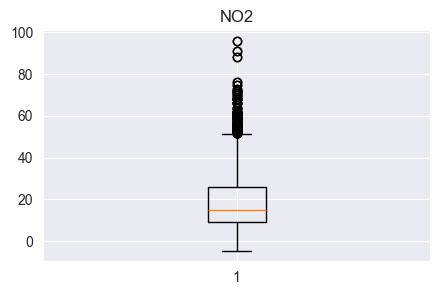

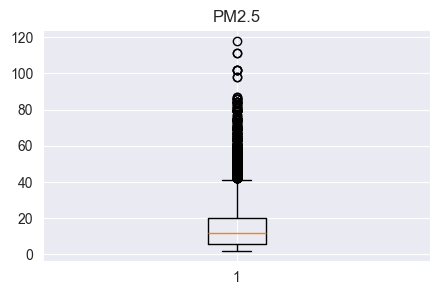

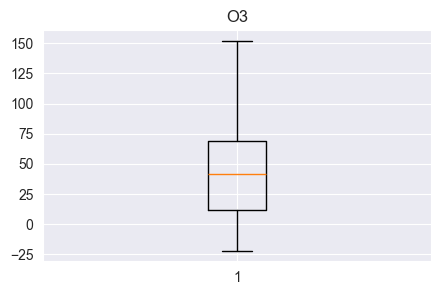

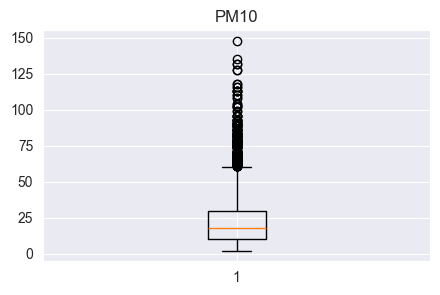

In [21]:
#check for outliers
columns_to_check = ['NO2', 'PM2.5', 'O3', 'PM10']

for column in columns_to_check:
    plt.figure(figsize=(5, 3))
    plt.boxplot(df[column])
    plt.title(column)
    plt.show()

Removing outliers using the z-score method

In [22]:
# Remove outliers from the DataFrame
# for column in columns_to_check:
#     z_score = (df[column] - df[column].mean()) / df[column].std()
#     threshold = 3  # 3 standard deviations
#     outliers = z_score[abs(z_score) > threshold]
#     print(column, outliers)
#     df = df[abs(z_score) <= threshold]
# 
# print('__________________')
# 
# # Recalculate Z-scores after outlier removal
# for column in columns_to_check:
#     z_score = (df[column] - df[column].mean()) / df[column].std()
#     threshold = 3
#     outliers = z_score[abs(z_score) > threshold]
#     print(column, outliers)

Removing outliers using the IQR method

In [23]:
# for column in columns_to_check:
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     
#     df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

Removing outliers using the IQR method, outliers are replaced by the median

In [24]:
# for column in columns_to_check:
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     
#     df[column] = df[column].mask(df[column] > upper_bound, df[column].median())

In [25]:
df.columns.tolist()

['Date',
 'Latitude',
 'Longitude',
 'Altitude',
 'NO2',
 'PM2.5',
 'O3',
 'PM10',
 'Year',
 'Month',
 'Day',
 'Hour',
 'temperature_2m (°C)',
 'relative_humidity_2m (%)',
 'dew_point_2m (°C)',
 'apparent_temperature (°C)',
 'precipitation (mm)',
 'rain (mm)',
 'snowfall (cm)',
 'surface_pressure (hPa)',
 'cloud_cover (%)',
 'wind_speed_10m (km/h)',
 'wind_direction_10m (°)',
 'soil_temperature_0_to_7cm (°C)',
 'soil_moisture_0_to_7cm (m³/m³)',
 'is_day ()']

Feature engineering

In [26]:
# PM2.5 and NO2 ratio
df['PM2.5/NO2'] = df['PM2.5'] / df['NO2']

# PM2.5 and O3 ratio
df['PM2.5/O3'] = df['PM2.5'] / df['O3']

# season
df['Season'] = df['Month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else ('Spring' if x in [3, 4, 5] else ('Summer' if x in [6, 7, 8] else 'Autumn')))

# weekend
df['Weekend'] = np.where(df['Date'].dt.dayofweek > 4, 1, 0)

Feature distribution plotting

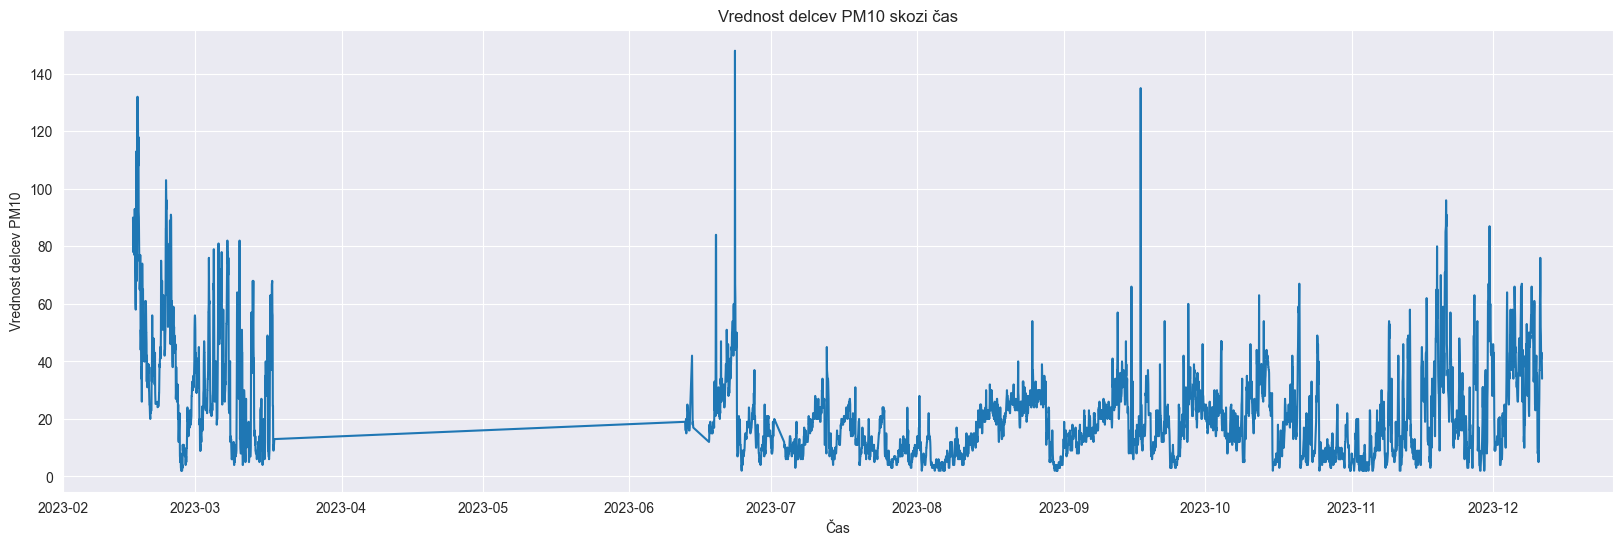

In [27]:
plt.figure(figsize=(20, 6))
plt.plot(df['Date'], df['PM10'])
plt.title('Vrednost delcev PM10 skozi čas')
plt.xlabel('Čas')
plt.ylabel('Vrednost delcev PM10')
plt.grid(True)
plt.show()

Latitude
46.234818    5625
Name: count, dtype: int64
Longitude
15.267305    5625
Name: count, dtype: int64
Altitude
240.0    5625
Name: count, dtype: int64
Year
2023    5625
Name: count, dtype: int64


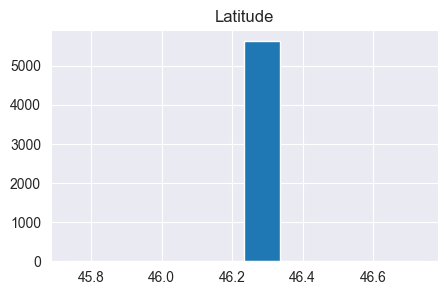

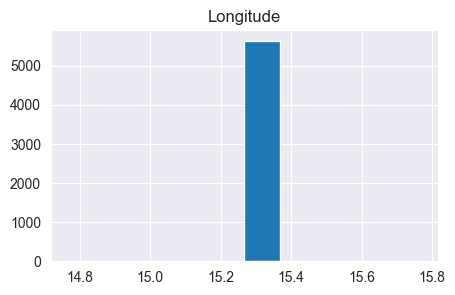

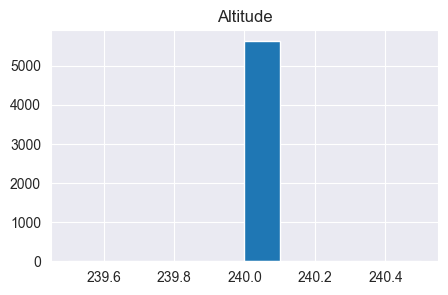

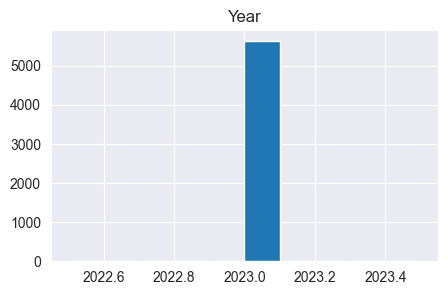

In [28]:
# constant features
for i in ['Latitude', 'Longitude', 'Altitude', 'Year']:
    print(df[i].value_counts())

for column in ['Latitude', 'Longitude', 'Altitude', 'Year']:
    plt.figure(figsize=(5, 3))
    plt.hist(df[column])
    plt.title(column)
    plt.show()

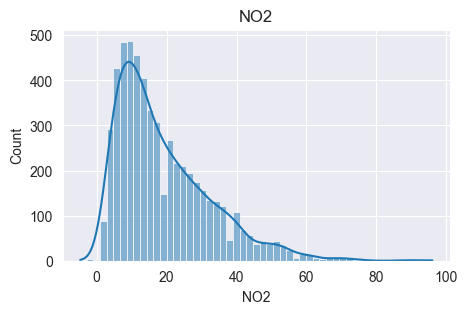

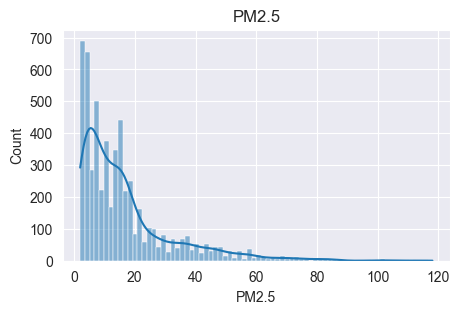

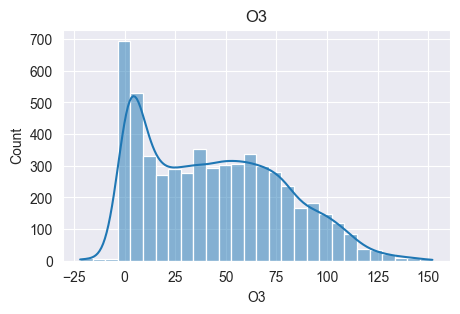

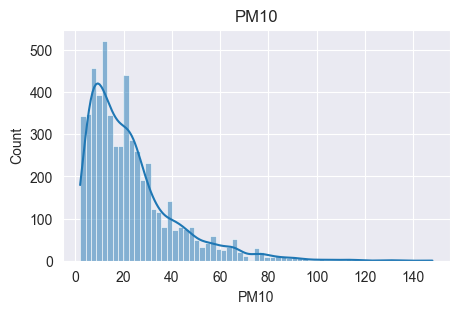

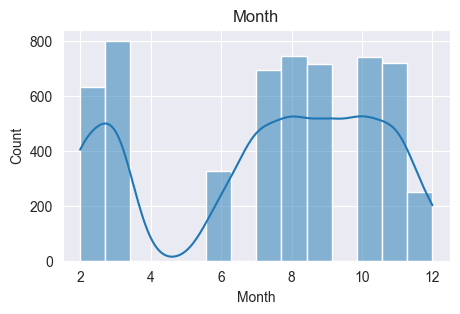

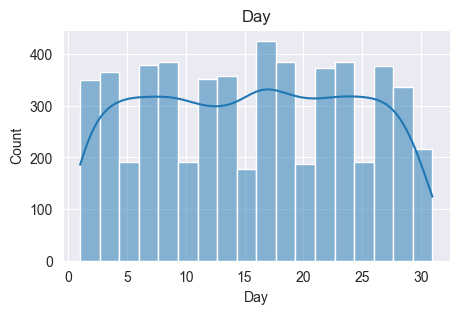

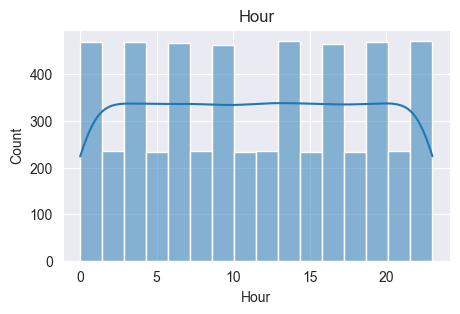

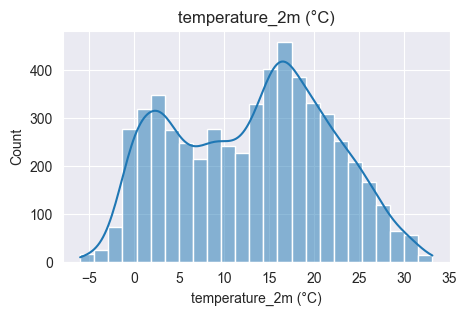

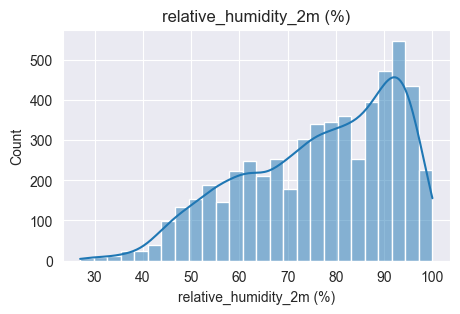

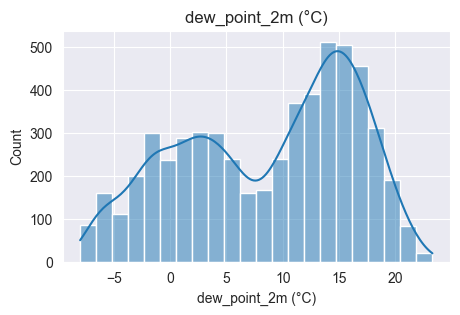

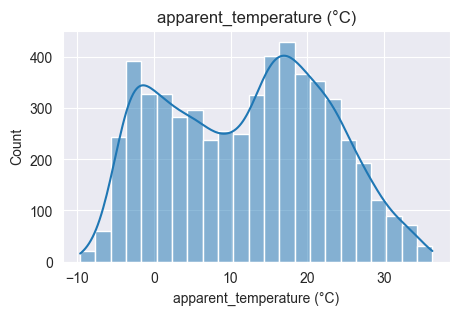

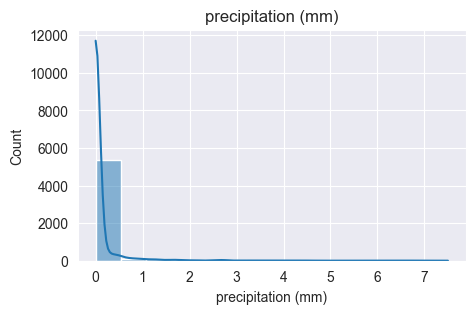

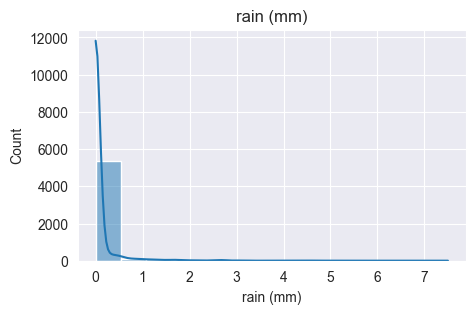

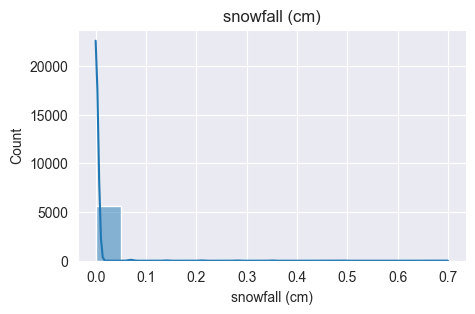

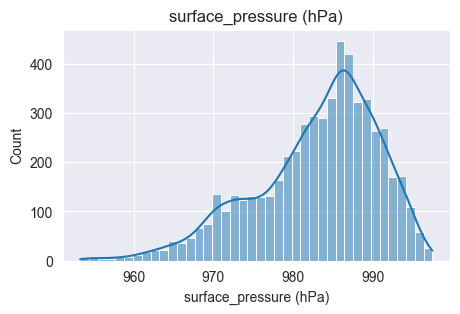

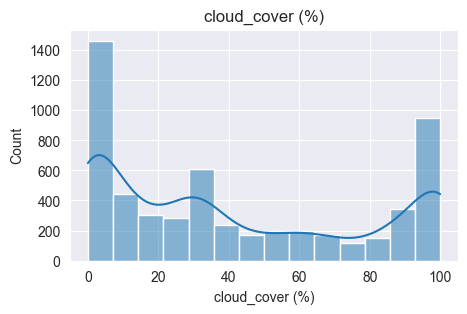

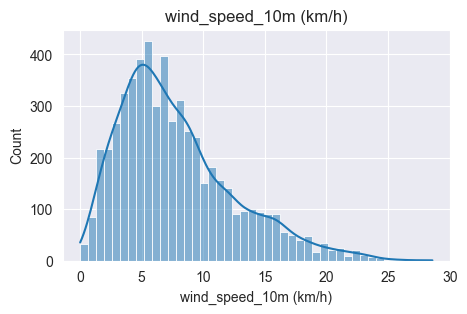

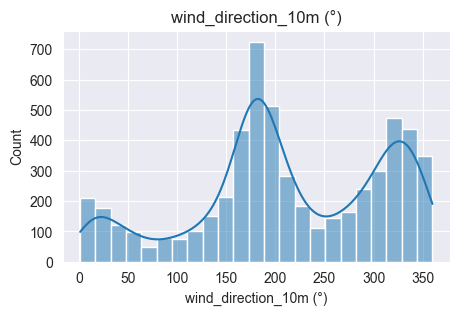

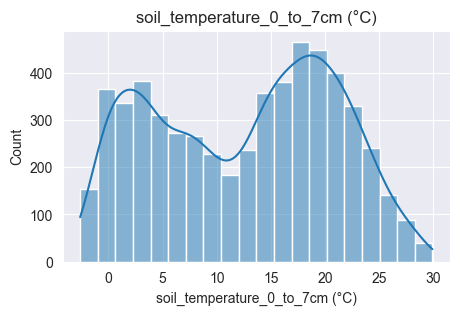

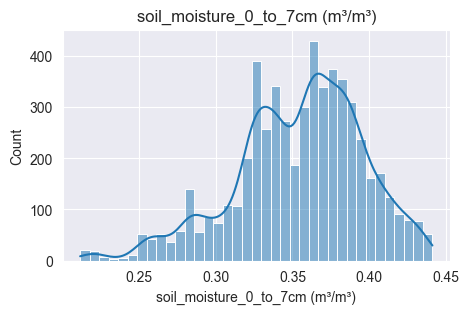

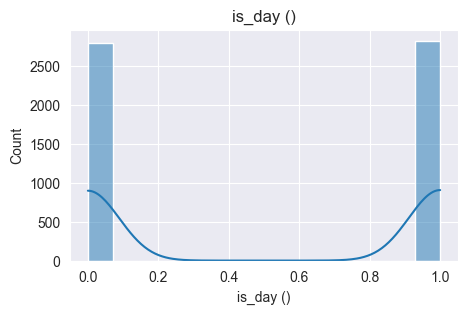

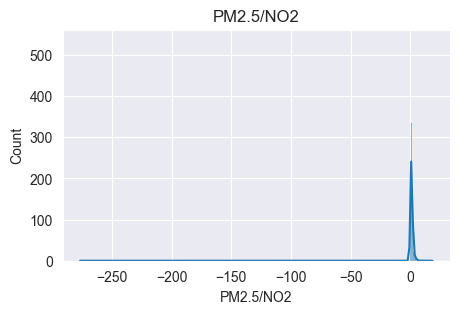

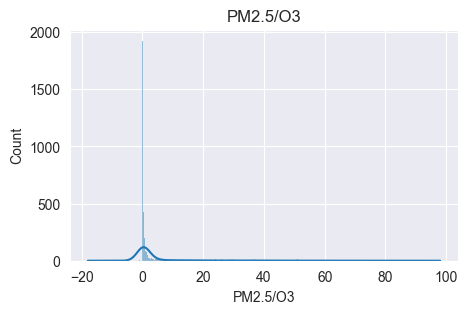

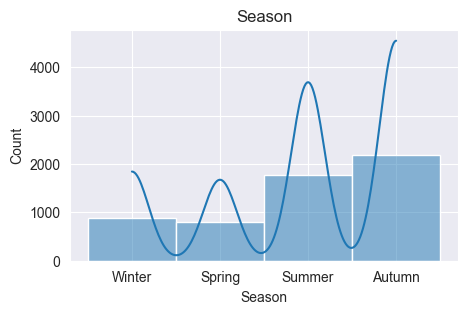

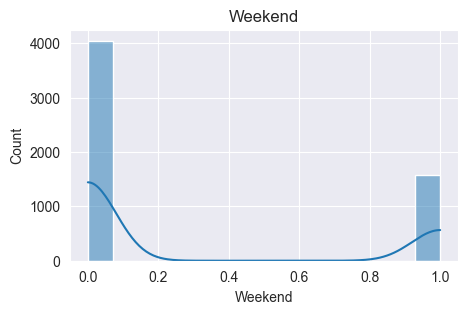

In [29]:
for column in df.columns.tolist():
    if column not in ['Date', 'Latitude', 'Longitude', 'Altitude', 'Year']:
        plt.figure(figsize=(5, 3))
        sns.histplot(data=df, x=column, kde=True)
        plt.title(column)
        plt.show()

In [30]:
columns = df.columns.tolist()
for i in ['Date', 'Year', 'Month', 'Day', 'Hour', 'Weekend', 'Season', 'Latitude', 'Longitude', 'Altitude', 'is_day ()']: columns.remove(i)

columns_with_zeros_or_negatives = []
for i in columns:
    if (df[i] <= 0).any():
        columns_with_zeros_or_negatives.append(i)

columns = list(filter(lambda x: x not in columns_with_zeros_or_negatives, columns))

print(columns)
print(columns_with_zeros_or_negatives)

['PM2.5', 'PM10', 'relative_humidity_2m (%)', 'surface_pressure (hPa)', 'wind_direction_10m (°)', 'soil_moisture_0_to_7cm (m³/m³)']
['NO2', 'O3', 'temperature_2m (°C)', 'dew_point_2m (°C)', 'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)', 'snowfall (cm)', 'cloud_cover (%)', 'wind_speed_10m (km/h)', 'soil_temperature_0_to_7cm (°C)', 'PM2.5/NO2', 'PM2.5/O3']


One-hot encoding

In [31]:
df = pd.get_dummies(df)

In [32]:
# removing the constants from dataframe
for i in ['Latitude', 'Longitude', 'Altitude', 'Year']:
    df.drop(i, axis=1, inplace=True)

In [33]:
# df copy for later use
df_copy = df.copy()

In [34]:
# data transformation, normal distribution, except for dates because they are discrete values
def transform_data(col):
    df[col], _  = boxcox(df[col])

    
def transform_neg_zero_data(col):
    df[col] = df[col]  + (abs(df[col].min()) + 1)
    df[col], _ = boxcox(df[col])
    
def transform_data_yeojohnson(col):
    df[col], _ = yeojohnson(df[col])
    
# tried to transform data with boxcox and yeo-johnson, but it overflowed because of extreme values
# df['PM2.5'], _  = boxcox(df['PM2.5']) 
# df['surface_pressure (hPa)'], _ = yeojohnson(df['surface_pressure (hPa)'])
columns.remove('surface_pressure (hPa)')
columns.remove('PM10')


for i in columns:
    transform_data(i)

# for i in columns_with_zeros_or_negatives:
#     transform_neg_zero_data(i)
    
for i in columns_with_zeros_or_negatives:
    transform_data_yeojohnson(i)

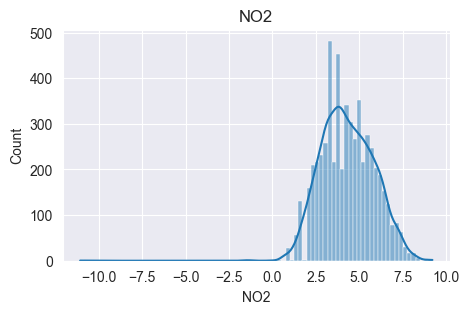

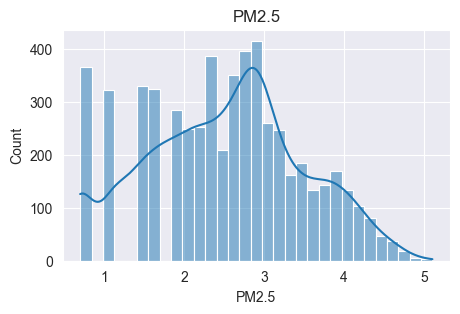

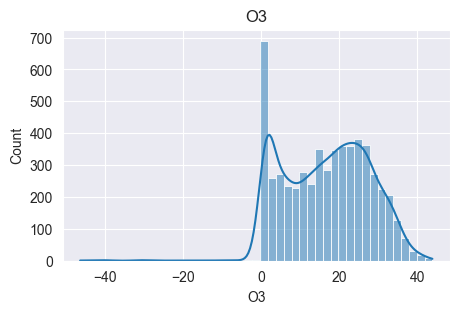

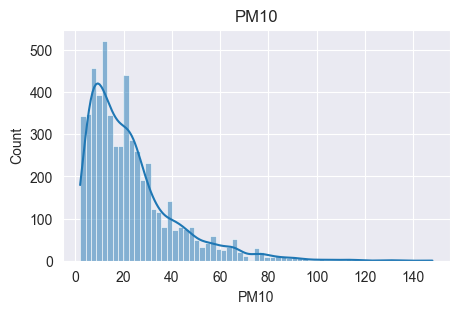

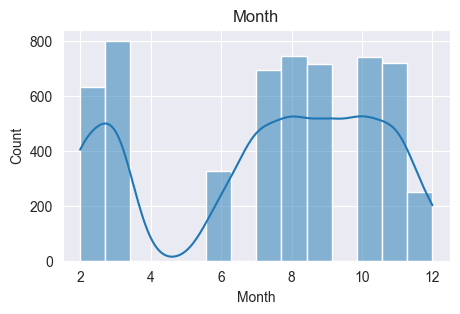

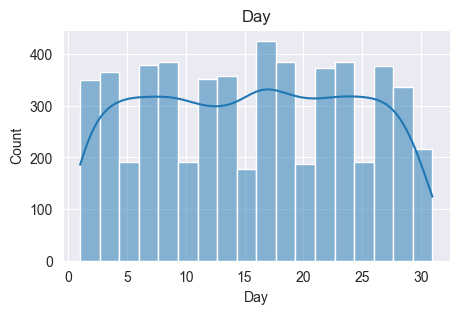

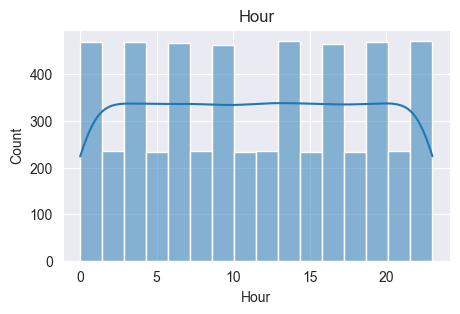

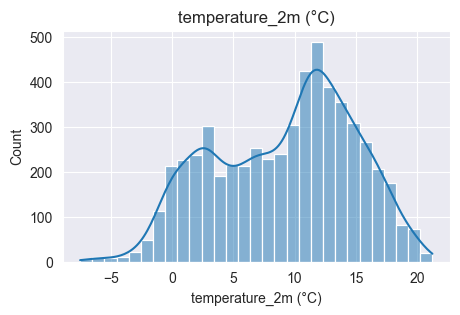

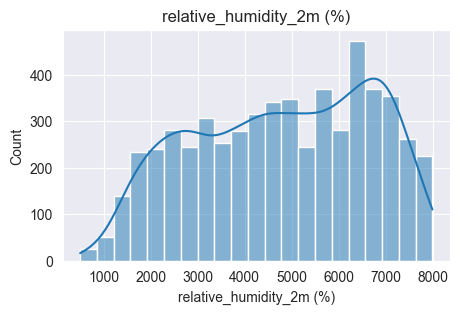

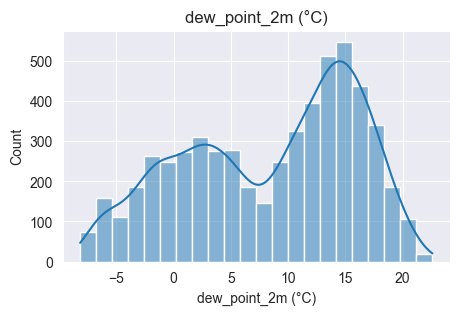

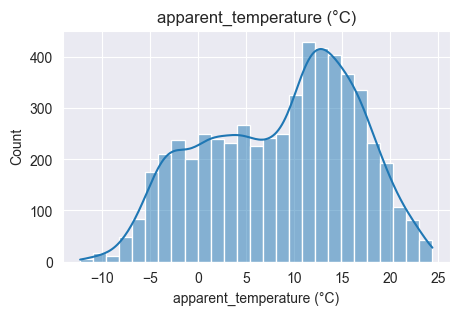

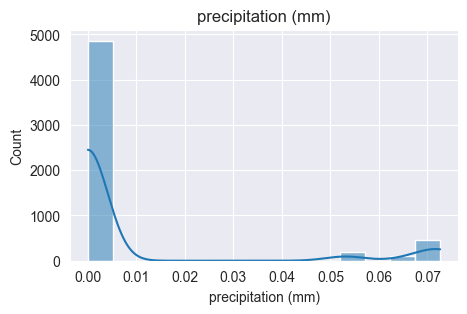

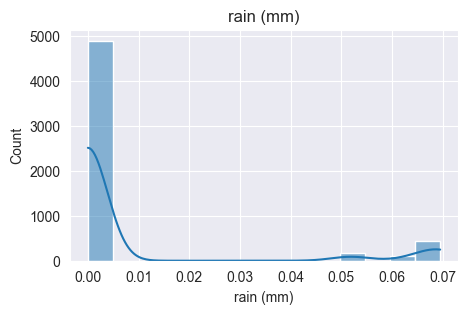

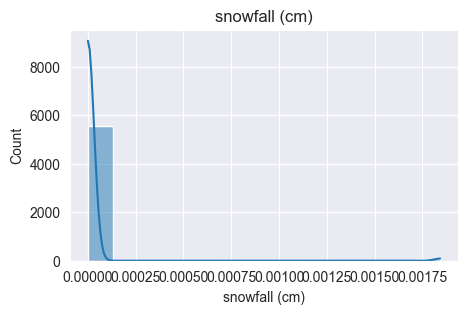

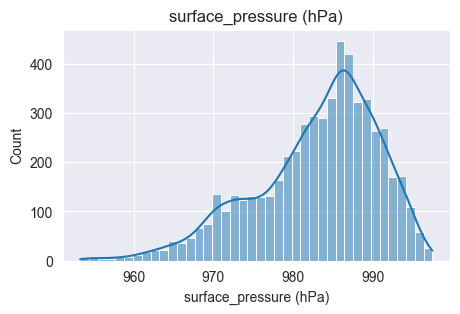

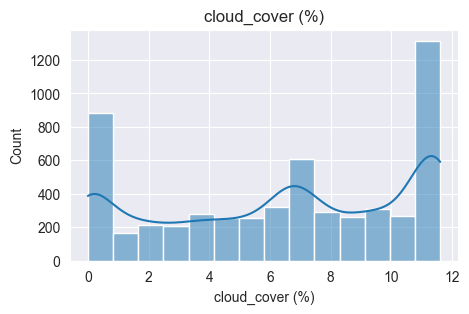

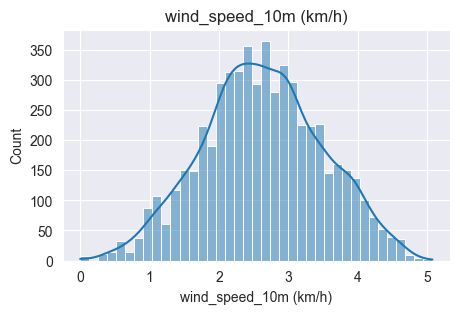

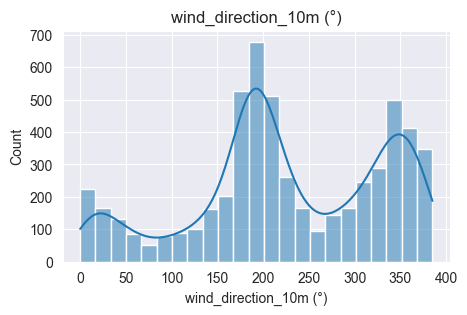

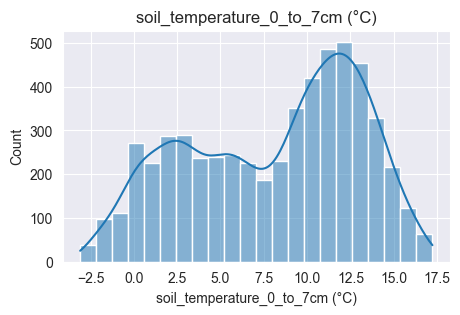

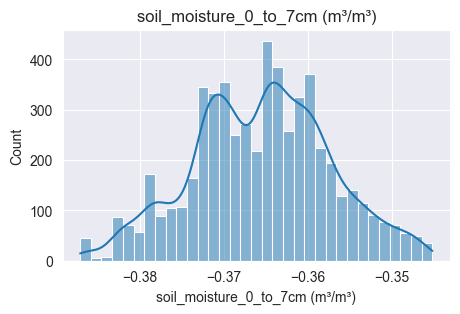

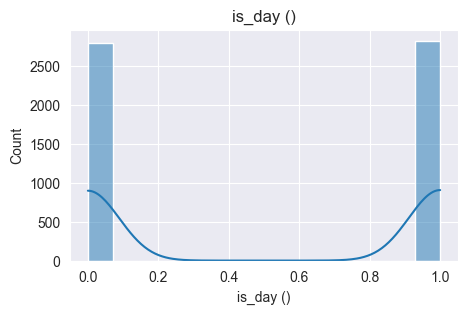

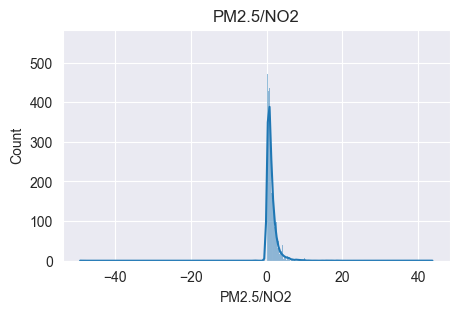

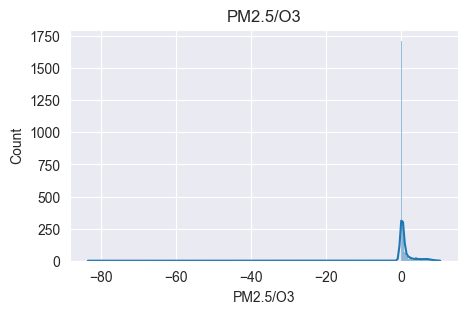

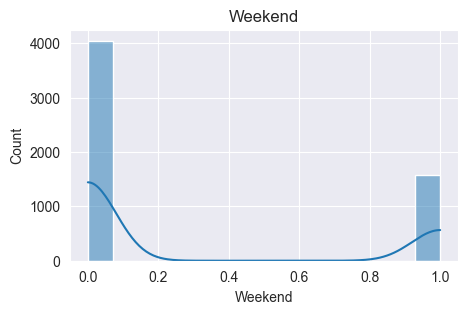

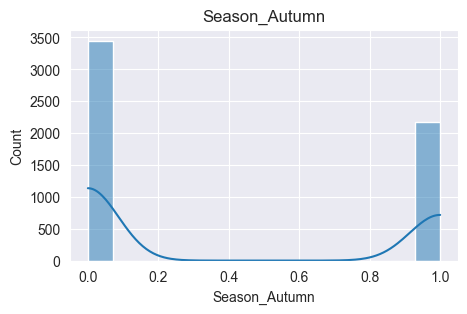

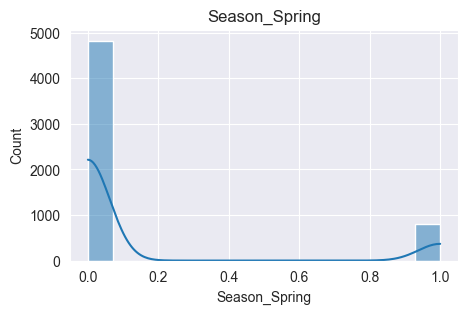

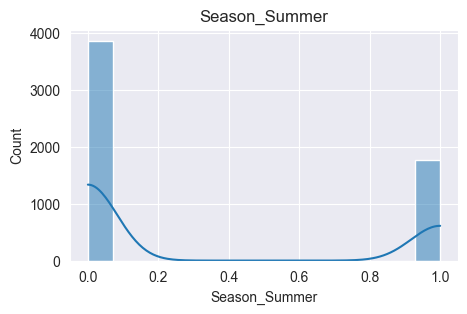

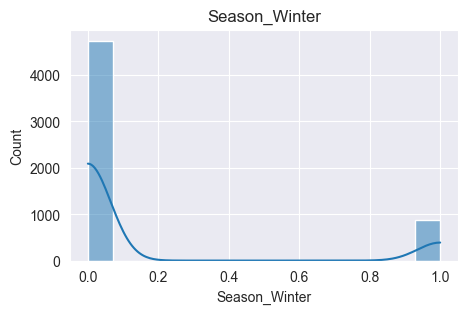

In [35]:
for column in df.columns.tolist():
    if column != 'Date':
        plt.figure(figsize=(5, 3))
        sns.histplot(data=df, x=column, kde=True)
        plt.title(column)
        plt.show()

In [37]:
input_data = df.columns.tolist()
input_data.remove('Date')
output_data = 'PM10'
input_data.remove(output_data)

ig_scores = mutual_info_regression(df[input_data], df[output_data])

feature_scores = pd.DataFrame({'Feature': df[input_data].columns, 'Information_Gain': ig_scores})
feature_scores = feature_scores.sort_values(by='Information_Gain', ascending=False)

feature_scores.reset_index(drop=True, inplace=True)
feature_scores.head(20)

Feature  Information_Gain
0                            PM2.5          1.544713
1                         PM2.5/O3          0.820684
2                        PM2.5/NO2          0.541548
3   soil_moisture_0_to_7cm (m³/m³)          0.513990
4                dew_point_2m (°C)          0.395197
5   soil_temperature_0_to_7cm (°C)          0.378005
6        apparent_temperature (°C)          0.327499
7                               O3          0.312102
8              temperature_2m (°C)          0.310705
9                              NO2          0.307830
10                             Day          0.295829
11          surface_pressure (hPa)          0.282689
12                           Month          0.239049
13           wind_speed_10m (km/h)          0.152269
14          wind_direction_10m (°)          0.151233
15                 cloud_cover (%)          0.134307
16        relative_humidity_2m (%)          0.123931
17                   Season_Winter          0.097620
18                            Hour          0.085238
19                   Season_Summer          0.063375

In [38]:
normally_distributed = ['temperature_2m (°C)', 'relative_humidity_2m (%)', 'apparent_temperature (°C)', 'wind_speed_10m (km/h)', 'soil_moisture_0_to_7cm (m³/m³)']

standard_scaler = StandardScaler()
df[normally_distributed] = standard_scaler.fit_transform(df[normally_distributed])

In [39]:
df.head(10)

Date       NO2     PM2.5         O3  PM10  Month  Day  \
0 2023-02-15 19:35:00+00:00  8.149562  4.529345 -27.135807  90.0      2   15   
1 2023-02-15 20:15:00+00:00  7.455299  4.606161   1.635371  86.0      2   15   
2 2023-02-15 20:35:00+00:00  7.455299  4.606161   1.635371  86.0      2   15   
3 2023-02-15 21:15:00+00:00  7.001226  4.560684   1.635371  78.0      2   15   
4 2023-02-15 21:35:00+00:00  7.001226  4.560684   1.635371  78.0      2   15   
5 2023-02-15 22:15:00+00:00  6.753790  4.719399   1.635371  89.0      2   15   
6 2023-02-15 22:35:00+00:00  6.753790  4.719399   1.635371  89.0      2   15   
7 2023-02-15 23:15:00+00:00  6.056701  4.591199   1.635371  78.0      2   15   
8 2023-02-15 23:35:00+00:00  6.056701  4.591199   1.635371  78.0      2   15   
9 2023-02-16 00:15:00+00:00  5.900386  4.649926   1.635371  83.0      2   16   

   Hour  temperature_2m (°C)  relative_humidity_2m (%)  ...  \
0    19            -1.534619                  0.937134  ...   
1    20            -1.602000                  1.018810  ...   
2    20            -1.602000                  1.018810  ...   
3    21            -1.827666                  1.101482  ...   
4    21            -1.827666                  1.101482  ...   
5    22            -1.673550                  0.856451  ...   
6    22            -1.673550                  0.856451  ...   
7    23            -1.655254                  0.776761  ...   
8    23            -1.655254                  0.776761  ...   
9     0            -1.692090                  0.937134  ...   

   soil_temperature_0_to_7cm (°C)  soil_moisture_0_to_7cm (m³/m³)  is_day ()  \
0                        0.384571                       -0.252121        0.0   
1                        0.195873                       -0.252121        0.0   
2                        0.195873                       -0.252121        0.0   
3                        0.098929                       -0.252121        0.0   
4                        0.098929                       -0.252121        0.0   
5                        0.000000                       -0.252121        0.0   
6                        0.000000                       -0.252121        0.0   
7                       -0.101086                       -0.252121        0.0   
8                       -0.101086                       -0.252121        0.0   
9                       -2.444073                       -0.300288        0.0   

   PM2.5/NO2   PM2.5/O3  Weekend  Season_Autumn  Season_Spring  Season_Summer  \
0   1.184679 -11.294744        0          False          False          False   
1   1.649598   6.913660        0          False          False          False   
2   1.649598   6.913660        0          False          False          False   
3   1.881303   6.789403        0          False          False          False   
4   1.881303   6.789403        0          False          False          False   
5   2.454243   7.229776        0          False          False          False   
6   2.454243   7.229776        0          False          False          False   
7   2.913020   6.872610        0          False          False          False   
8   2.913020   6.872610        0          False          False          False   
9   3.333481   7.034692        0          False          False          False   

   Season_Winter  
0           True  
1           True  
2           True  
3           True  
4           True  
5           True  
6           True  
7           True  
8           True  
9           True  

[10 rows x 29 columns]

In [40]:
start_date = df[df['Date'].dt.hour == 00].iloc[0]['Date']
end_date = start_date + pd.DateOffset(days=1)

rows_between = df[(df['Date'] >= start_date) & (df['Date'] < end_date)].shape[0]
print('Rows between different dates:', rows_between)

Rows between different dates: 48


In [41]:
# recommended max window size for this project is 4 weeks
# weeks = 2
# window_size = rows_between * (weeks * 7)
window_size = 48

### Univariate time series model

In [42]:
filtered_df = df['PM10']
dataset = filtered_df.values

In [43]:
test_data_size = round(0.2 * len(dataset))

train_data = dataset[:-test_data_size]
test_data = dataset[-test_data_size:]

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (4500,)
Test data shape: (1125,)


In [44]:
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

In [45]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [46]:
def create_time_series(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size)]
        X.append(window)
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [47]:
X_train, y_train = create_time_series(train_data, window_size)
X_test, y_test = create_time_series(test_data, window_size)

In [48]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [49]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (4452, 1, 48)
Shape of X_test: (1077, 1, 48)
Shape of y_train: (4452, 1)
Shape of y_test: (1077, 1)


In [50]:
# testing different models
model_rnn = Sequential([
    SimpleRNN(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(32),
    Dense(16, activation='relu'),
    Dense(1)
], name='RNN')

model_gru = Sequential([
    GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(32),
    Dense(16, activation='relu'),
    Dense(1)
], name='GRU')

model_lstm = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1)
], name='LSTM')

2024-01-22 09:42:07.653337: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-22 09:42:07.653380: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-22 09:42:07.653386: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-22 09:42:07.653603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-22 09:42:07.653943: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [51]:
# Enhanced models with more layers
model_advanced_rnn = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.2, recurrent_dropout=0.2),
    SimpleRNN(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu', kernel_regularizer=L2(0.01)),
    Dense(1)
], name='RNN')

model_advanced_gru = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.3, recurrent_dropout=0.2),
    GRU(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),
    GRU(64, dropout=0.3, recurrent_dropout=0.2),
    Dense(32, activation='relu', kernel_regularizer=L2(0.01)),
    Dense(1)
], name='GRU')

model_advanced_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.3, recurrent_dropout=0.3),
    LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dense(32, activation='tanh', kernel_regularizer=L2(0.01)),
    Dense(1)
], name='LSTM')

In [52]:
# Bidirectional layer
model_bi_rnn = Sequential([
    Bidirectional(SimpleRNN(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), input_shape=(X_train.shape[1], X_train.shape[2])),
    Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation='relu', kernel_regularizer=L2(0.01)),
    Dense(1)
], name='RNN')

model_bi_gru = Sequential([
    Bidirectional(GRU(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2), input_shape=(X_train.shape[1], X_train.shape[2])),
    Bidirectional(GRU(64, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)),
    Bidirectional(GRU(64, dropout=0.3, recurrent_dropout=0.2)),
    Dense(32, activation='relu', kernel_regularizer=L2(0.01)),
    Dense(1)
], name='GRU')

model_bi_lstm = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3), input_shape=(X_train.shape[1], X_train.shape[2])),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(32, activation='tanh', kernel_regularizer=L2(0.01)),
    Dense(1)
], name='LSTM')

In [53]:
models = [model_rnn, model_gru, model_lstm]

In [54]:
history = {}
for model in models:
    model.compile(optimizer='adam', loss='mse')
    hist = model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2)
    history[model.name] = hist.history

Epoch 1/50


2024-01-22 09:42:24.051823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


70/70 - 2s - loss: 0.0084 - 2s/epoch - 32ms/step
Epoch 2/50
70/70 - 1s - loss: 0.0037 - 977ms/epoch - 14ms/step
Epoch 3/50
70/70 - 1s - loss: 0.0027 - 965ms/epoch - 14ms/step
Epoch 4/50
70/70 - 1s - loss: 0.0021 - 979ms/epoch - 14ms/step
Epoch 5/50
70/70 - 1s - loss: 0.0020 - 986ms/epoch - 14ms/step
Epoch 6/50
70/70 - 1s - loss: 0.0018 - 989ms/epoch - 14ms/step
Epoch 7/50
70/70 - 1s - loss: 0.0018 - 983ms/epoch - 14ms/step
Epoch 8/50
70/70 - 1s - loss: 0.0017 - 978ms/epoch - 14ms/step
Epoch 9/50
70/70 - 1s - loss: 0.0016 - 980ms/epoch - 14ms/step
Epoch 10/50
70/70 - 1s - loss: 0.0016 - 972ms/epoch - 14ms/step
Epoch 11/50
70/70 - 1s - loss: 0.0016 - 994ms/epoch - 14ms/step
Epoch 12/50
70/70 - 1s - loss: 0.0015 - 980ms/epoch - 14ms/step
Epoch 13/50
70/70 - 1s - loss: 0.0015 - 984ms/epoch - 14ms/step
Epoch 14/50
70/70 - 1s - loss: 0.0015 - 981ms/epoch - 14ms/step
Epoch 15/50
70/70 - 1s - loss: 0.0015 - 987ms/epoch - 14ms/step
Epoch 16/50
70/70 - 1s - loss: 0.0015 - 983ms/epoch - 14ms/step

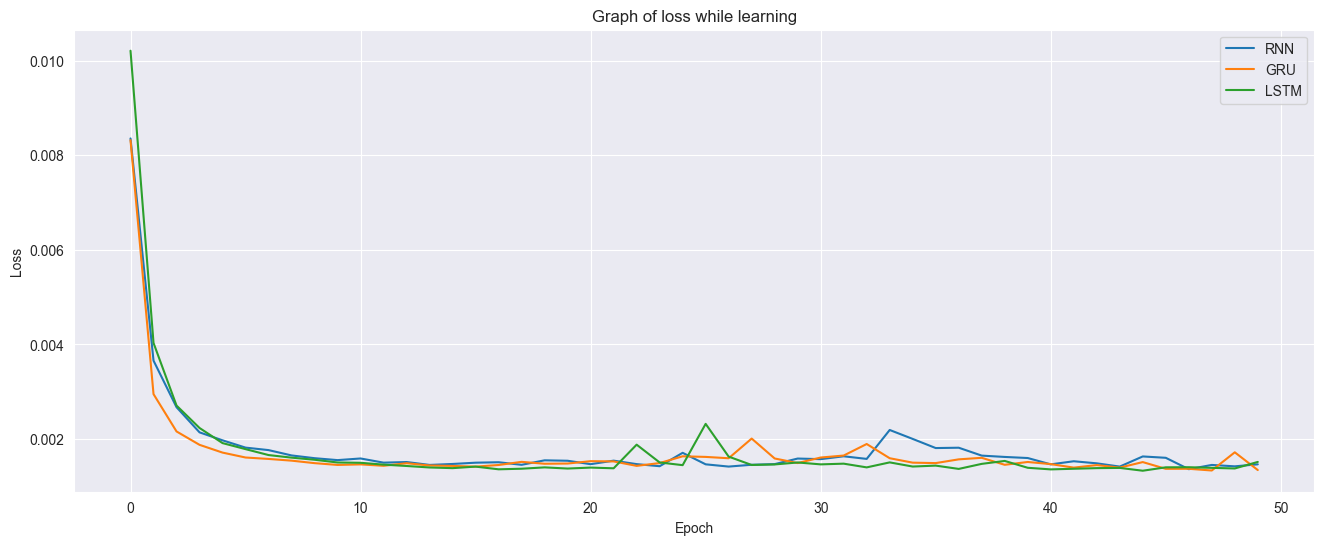

In [55]:
plt.figure(figsize=(16, 6))
for name, values in history.items():
    plt.plot(values['loss'], label=name)
plt.title('Graph of loss while learning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
metrics = ['MSE', 'MAE', 'EVS']
def report(models, X_test, y_test, scaler):
    results = {
        'MSE': [],
        'MAE': [],
        'EVS': []
    }
    y_test = scaler.inverse_transform(y_test)
    for model in models:
        predicted = model.predict(X_test, verbose=0)
        predicted = scaler.inverse_transform(predicted)
       
        mse = mean_squared_error(y_test, predicted)
        mae = mean_absolute_error(y_test, predicted)
        evs = explained_variance_score(y_test, predicted)
        print(f'{model.name}:')
        print(f' MSE: {mse:.2f}')
        print(f' MAE: {mae:.2f}')
        print(f' EVS: {evs:.2f}')
        print()
        results['MSE'].append((model.name, mse))
        results['MAE'].append((model.name, mae))
        results['EVS'].append((model.name, evs))
    return results

In [57]:
regression_report = report(models, X_test, y_test, scaler)

RNN:
 MSE: 45.63
 MAE: 4.71
 EVS: 0.86
GRU:
 MSE: 43.06
 MAE: 4.59
 EVS: 0.87
LSTM:
 MSE: 43.47
 MAE: 4.44
 EVS: 0.87


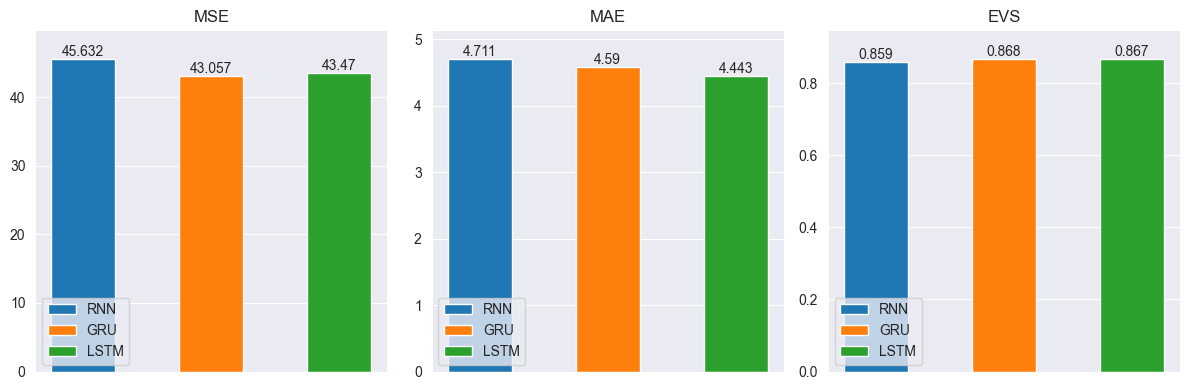

In [58]:
width = 0.5
rows = 1
cols = len(metrics)

fig, axs = plt.subplots(rows, cols, figsize=(12, 4))

for i, metric in enumerate(metrics):
    ax = axs[i]
    max = -float('inf')


    for j, model in enumerate(models):
        value = regression_report[metric][j][1]
        if value > max:
          max = value
        ax.bar(j, value, width, label=model.name)
        ax.text(j, value, str(round(value, 3)), ha='center', va='bottom')


    ax.set_ylim([0, max * 1.09])
    ax.set_title(f'{metric}')
    ax.set_xticks([], [])
    ax.legend(loc='lower left')

plt.tight_layout()
plt.show()

In [59]:
dates = df['Date'].values
print(dates)

['2023-02-15T19:35:00.000000000' '2023-02-15T20:15:00.000000000'
 '2023-02-15T20:35:00.000000000' ... '2023-12-11T06:35:00.000000000'
 '2023-12-11T07:35:00.000000000' '2023-12-11T08:35:00.000000000']


In [60]:
inverse_y_test = scaler.inverse_transform(y_test)
predictions = {}

for model in models:
    predicted = model.predict(X_test, verbose=0)
    predicted = scaler.inverse_transform(predicted)
    predictions[model.name] = predicted

In [61]:
output_df = {}

for model in models:
    data = {
        'Date': dates[-test_data_size + window_size:],
        'True': inverse_y_test.reshape(-1),
        'Predicted': predictions[model.name].reshape(-1)
    }
    output_df[model.name] = pd.DataFrame(data)

In [62]:
output_df['RNN'].head()

Date  True  Predicted
0 2023-10-27 12:35:00   5.0   6.624611
1 2023-10-27 13:35:00   3.0   5.767520
2 2023-10-27 14:35:00   4.0   4.316464
3 2023-10-27 15:35:00   3.0   5.811451
4 2023-10-27 16:35:00   4.0   3.968017

In [63]:
output_df['GRU'].head()

Date  True  Predicted
0 2023-10-27 12:35:00   5.0   7.009814
1 2023-10-27 13:35:00   3.0   6.114794
2 2023-10-27 14:35:00   4.0   4.612533
3 2023-10-27 15:35:00   3.0   4.949141
4 2023-10-27 16:35:00   4.0   4.626400

In [64]:
output_df['LSTM'].head()

Date  True  Predicted
0 2023-10-27 12:35:00   5.0   6.684122
1 2023-10-27 13:35:00   3.0   5.621560
2 2023-10-27 14:35:00   4.0   4.403050
3 2023-10-27 15:35:00   3.0   5.163572
4 2023-10-27 16:35:00   4.0   4.424088

In [65]:
validation_date = output_df['RNN']['Date'].iloc[1]
df[df['Date'] == str(validation_date)]

Date      NO2     PM2.5         O3  PM10  Month  \
4549 2023-10-27 13:35:00+00:00  4.99515  0.699963  13.781094   3.0     10   

      Day  Hour  temperature_2m (°C)  relative_humidity_2m (%)  ...  \
4549   27    13              0.39978                  -0.23543  ...   

      soil_temperature_0_to_7cm (°C)  soil_moisture_0_to_7cm (m³/m³)  \
4549                        9.814203                         1.87296   

      is_day ()  PM2.5/NO2  PM2.5/O3  Weekend  Season_Autumn  Season_Spring  \
4549        1.0   0.092491  0.065202        0           True          False   

      Season_Summer  Season_Winter  
4549          False          False  

[1 rows x 29 columns]

In [66]:
def line_plot_test_data(df, model_name):
    plt.figure(figsize=(12, 8))
    plt.plot(df['Date'], df['True'], label='True')
    plt.plot(df['Date'], df['Predicted'], label=model_name)
    plt.xlabel('Čas')
    plt.ylabel('Vrednost PM10')
    plt.title('Vrednost PM10 glede na čas')
    plt.legend()
    plt.show()

In [67]:
def line_plot_all_data(df, model_df, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'].iloc[:-test_data_size], df['PM10'].iloc[:-test_data_size], label='Train')
    plt.plot(model_df['Date'], model_df['Predicted'], label=model_name, color='green')
    plt.plot(df['Date'].iloc[-test_data_size:], df['PM10'].iloc[-test_data_size:], label='Test')
    plt.xlabel('Čas')
    plt.ylabel('Vrednost PM10')
    plt.title('Vrednost PM10 glede na čas')
    plt.legend()
    plt.show()

RNN


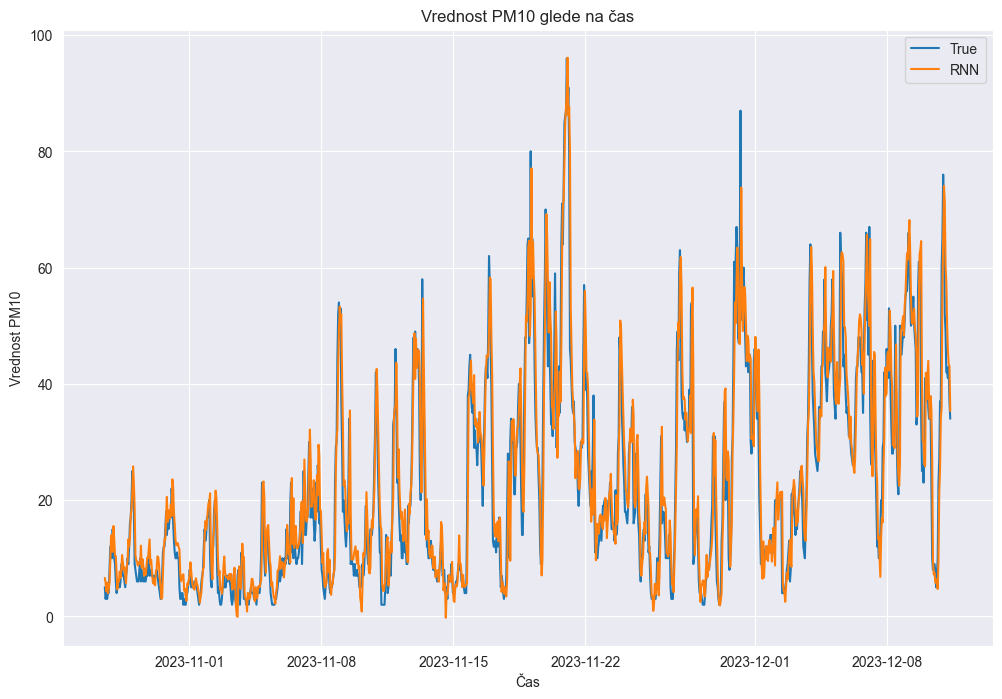

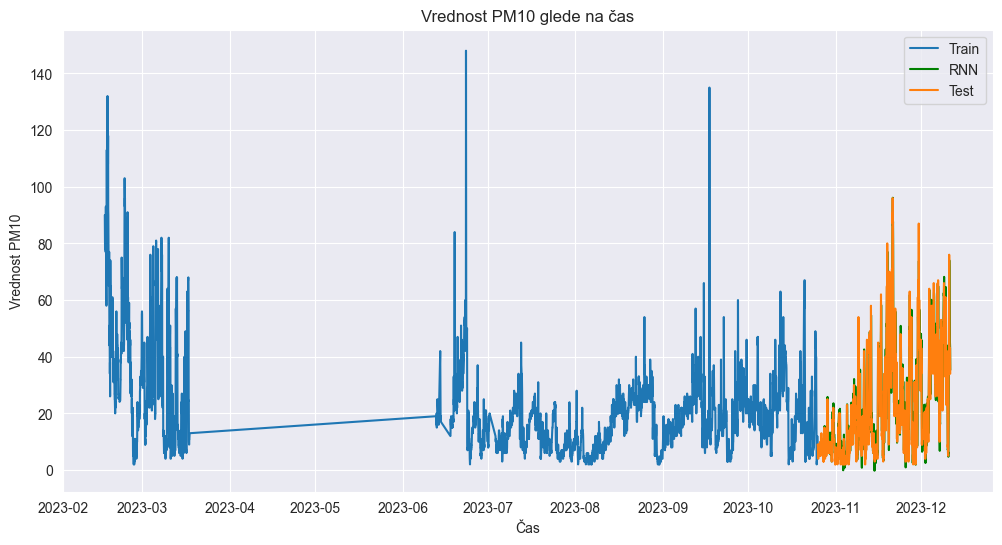

GRU


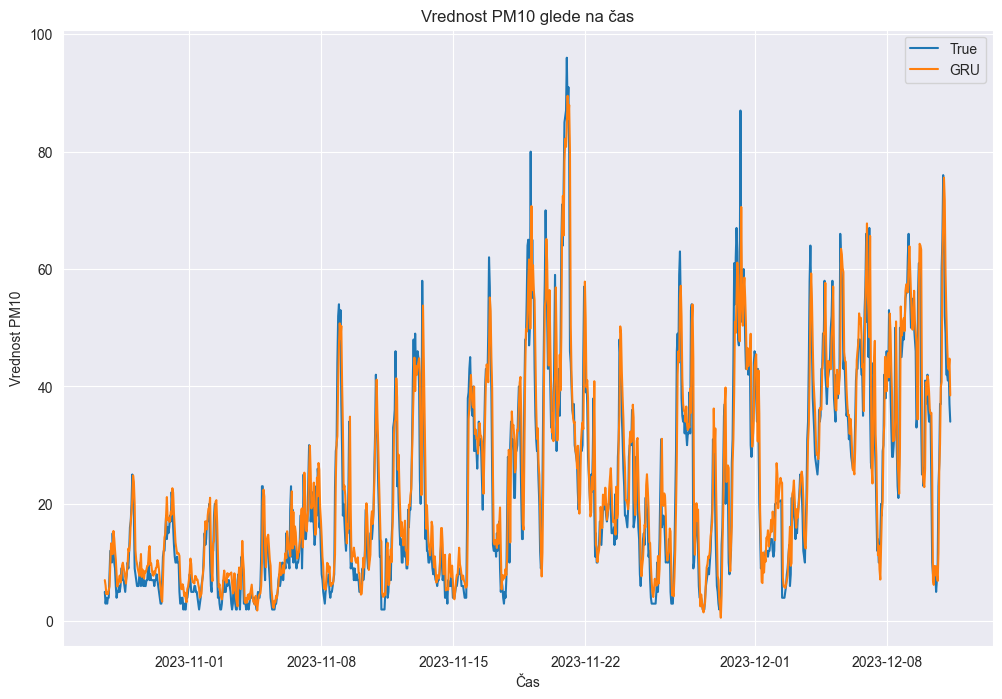

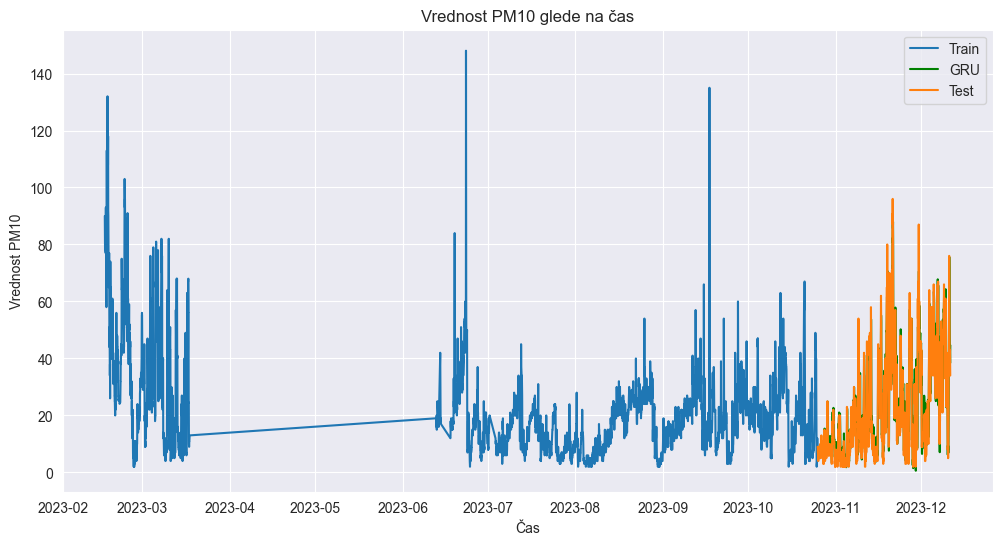

LSTM


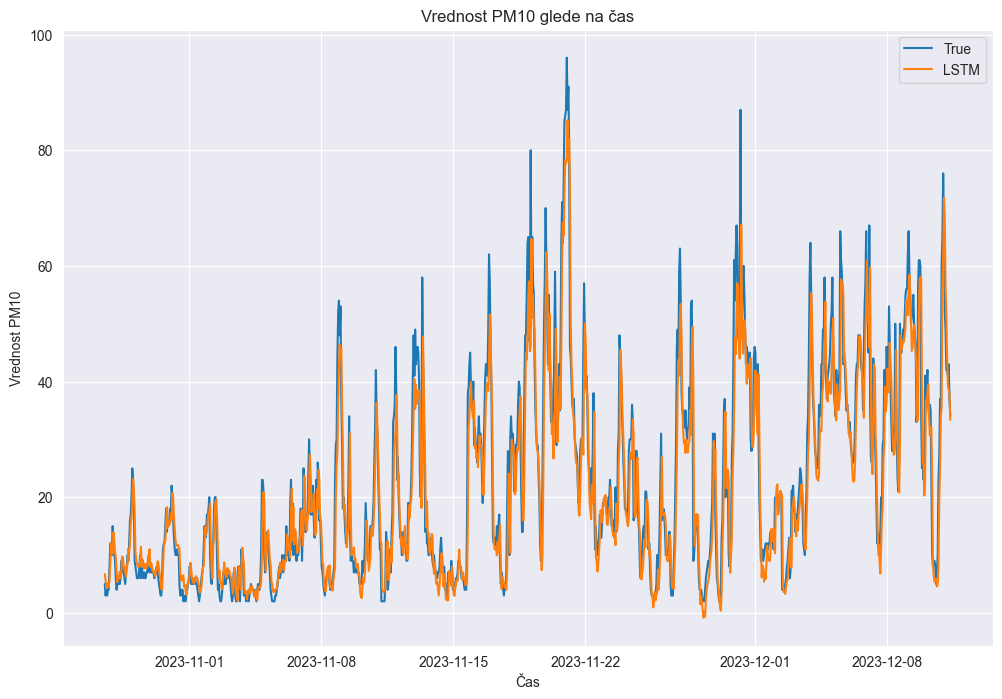

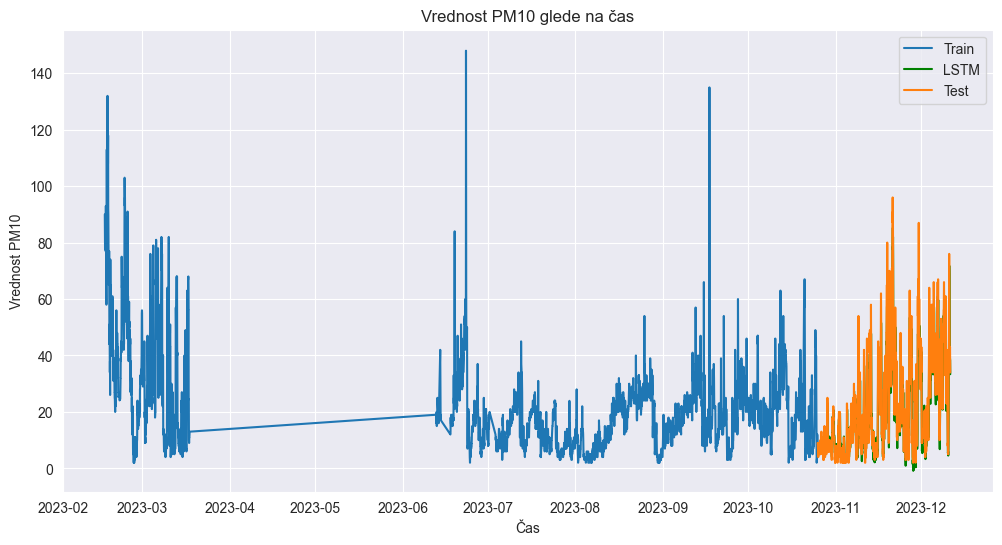

In [68]:
for model in models:
    print(model.name)
    line_plot_test_data(output_df[model.name], model.name)
    line_plot_all_data(df, output_df[model.name], model.name)

Performing a grid or randomize search on different models

In [401]:
params = {
    'model__units': [32, 64],
    'model__activation': ['relu', 'tanh', 'sigmoid'],
    'model__optimizer': ['adam', 'rmsprop', 'sgd'],
    'model__dropout': [0.0, 0.1, 0.2, 0.3],
    'epochs': [10, 25, 50, 100],
    'batch_size': [32, 64, 128]
}

def create_rnn_model(units=32, dropout=0.0, activation='relu', optimizer='adam'):
    model = Sequential([
        SimpleRNN(units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(dropout),
        SimpleRNN(units),
        Dropout(dropout),
        Dense(16, activation=activation),
        Dense(1)
    ], name='RNN')
    
    model.compile(optimizer=optimizer, loss='mse')
    return model

def create_gru_model(units=32, dropout=0.0, activation='relu', optimizer='adam'):
    model = Sequential([
        GRU(units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(dropout),
        GRU(units),
        Dropout(dropout),
        Dense(16, activation=activation),
        Dense(1)
    ], name='GRU')
    
    model.compile(optimizer=optimizer, loss='mse')
    return model

def create_lstm_model(units=32, dropout=0.0, activation='relu', optimizer='adam'):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(dropout),
        LSTM(units),
        Dropout(dropout),
        Dense(16, activation=activation),
        Dense(1)
    ], name='LSTM')
    
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [402]:
models = [create_rnn_model, create_gru_model, create_lstm_model]

In [403]:
score_metric = 'neg_mean_squared_error'
best_model = None
best_score = -float('inf')
best_models = {}

In [404]:
# grid search but it's slow and complex
# for model in models:
#     model = KerasRegressor(model=model, verbose=0)
#     grid_search = GridSearchCV(estimator=model,
#                                param_grid=params,
#                                scoring=score_metric,
#                                cv=3)
#     grid_search_result = grid_search.fit(X_train, y_train, verbose=1, validation_data=(X_test, y_test))
#     print(f'Best {score_metric}: {grid_search_result.best_score_}')
#     print('Best params:', grid_search_result.best_params_)
#     model_name = grid_search_result.best_estimator_.model.__name__
#     best_models[model_name] = {
#         'score': grid_search_result.best_score_,
#         'params': grid_search_result.best_params_,
#     }
# 
#     if grid_search_result.best_score_ > best_score:
#         best_score = grid_search_result.best_score_
#         best_model = grid_search_result.best_estimator_.model.__name__

In [405]:
# randomized search
for model in models:
    model = KerasRegressor(model=model, verbose=0)
    randomized_search = RandomizedSearchCV(estimator=model,
                              param_distributions=params,
                              scoring=score_metric,
                              cv=3,
                              n_iter=10,
                              random_state=1234)
    randomized_search_results = randomized_search.fit(X_train, y_train, verbose=1, validation_data=(X_test, y_test))
    print(f'Best {score_metric}: {randomized_search_results.best_score_}')
    print('Best params:', randomized_search_results.best_params_)
    model_name = randomized_search_results.best_estimator_.model.__name__
    best_models[model_name] = {
        'score': randomized_search_results.best_score_,
        'params': randomized_search_results.best_params_,
    }

    if randomized_search_results.best_score_ > best_score:
        best_score = randomized_search_results.best_score_
        best_model = randomized_search_results.best_estimator_.model.__name__

Epoch 1/50
47/47 [==============================] - 3s 46ms/step - loss: 0.0128 - val_loss: 0.0079
Epoch 2/50
47/47 [==============================] - 1s 25ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 3/50
47/47 [==============================] - 1s 25ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 4/50
47/47 [==============================] - 1s 24ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 5/50
47/47 [==============================] - 1s 24ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 6/50
47/47 [==============================] - 1s 23ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 7/50
47/47 [==============================] - 1s 24ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 8/50
47/47 [==============================] - 1s 24ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 9/50
47/47 [==============================] - 1s 24ms/step - loss: 0.0017 - val_loss: 0.0050
Epoch 10/50
47/47 [==============================] - 1s 23ms/step - loss: 0.0017 - val_loss: 0.0052
Epoch 11/

In [406]:
print('Best model:', best_model)
print(f'Best {score_metric}: {best_score}')

Best model: create_lstm_model
Best neg_mean_squared_error: -0.001685891880756983


### Multivariate time series model

In [407]:
# df = df_copy

In [69]:
df.head()

Date       NO2     PM2.5         O3  PM10  Month  Day  \
0 2023-02-15 19:35:00+00:00  8.149562  4.529345 -27.135807  90.0      2   15   
1 2023-02-15 20:15:00+00:00  7.455299  4.606161   1.635371  86.0      2   15   
2 2023-02-15 20:35:00+00:00  7.455299  4.606161   1.635371  86.0      2   15   
3 2023-02-15 21:15:00+00:00  7.001226  4.560684   1.635371  78.0      2   15   
4 2023-02-15 21:35:00+00:00  7.001226  4.560684   1.635371  78.0      2   15   

   Hour  temperature_2m (°C)  relative_humidity_2m (%)  ...  \
0    19            -1.534619                  0.937134  ...   
1    20            -1.602000                  1.018810  ...   
2    20            -1.602000                  1.018810  ...   
3    21            -1.827666                  1.101482  ...   
4    21            -1.827666                  1.101482  ...   

   soil_temperature_0_to_7cm (°C)  soil_moisture_0_to_7cm (m³/m³)  is_day ()  \
0                        0.384571                       -0.252121        0.0   
1                        0.195873                       -0.252121        0.0   
2                        0.195873                       -0.252121        0.0   
3                        0.098929                       -0.252121        0.0   
4                        0.098929                       -0.252121        0.0   

   PM2.5/NO2   PM2.5/O3  Weekend  Season_Autumn  Season_Spring  Season_Summer  \
0   1.184679 -11.294744        0          False          False          False   
1   1.649598   6.913660        0          False          False          False   
2   1.649598   6.913660        0          False          False          False   
3   1.881303   6.789403        0          False          False          False   
4   1.881303   6.789403        0          False          False          False   

   Season_Winter  
0           True  
1           True  
2           True  
3           True  
4           True  

[5 rows x 29 columns]

In [70]:
feature_scores.head(20)

Feature  Information_Gain
0                            PM2.5          1.544713
1                         PM2.5/O3          0.820684
2                        PM2.5/NO2          0.541548
3   soil_moisture_0_to_7cm (m³/m³)          0.513990
4                dew_point_2m (°C)          0.395197
5   soil_temperature_0_to_7cm (°C)          0.378005
6        apparent_temperature (°C)          0.327499
7                               O3          0.312102
8              temperature_2m (°C)          0.310705
9                              NO2          0.307830
10                             Day          0.295829
11          surface_pressure (hPa)          0.282689
12                           Month          0.239049
13           wind_speed_10m (km/h)          0.152269
14          wind_direction_10m (°)          0.151233
15                 cloud_cover (%)          0.134307
16        relative_humidity_2m (%)          0.123931
17                   Season_Winter          0.097620
18                            Hour          0.085238
19                   Season_Summer          0.063375

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'PM2.5'),
  Text(1, 0, 'PM2.5/O3'),
  Text(2, 0, 'PM2.5/NO2'),
  Text(3, 0, 'soil_moisture_0_to_7cm (m³/m³)'),
  Text(4, 0, 'dew_point_2m (°C)'),
  Text(5, 0, 'soil_temperature_0_to_7cm (°C)'),
  Text(6, 0, 'apparent_temperature (°C)'),
  Text(7, 0, 'O3'),
  Text(8, 0, 'temperature_2m (°C)'),
  Text(9, 0, 'NO2'),
  Text(10, 0, 'Day'),
  Text(11, 0, 'surface_pressure (hPa)'),
  Text(12, 0, 'Month'),
  Text(13, 0, 'wind_speed_10m (km/h)'),
  Text(14, 0, 'wind_direction_10m (°)'),
  Text(15, 0, 'cloud_cover (%)'),
  Text(16, 0, 'relative_humidity_2m (%)'),
  Text(17, 0, 'Season_Winter'),
  Text(18, 0, 'Hour'),
  Text(19, 0, 'Season_Summer')])

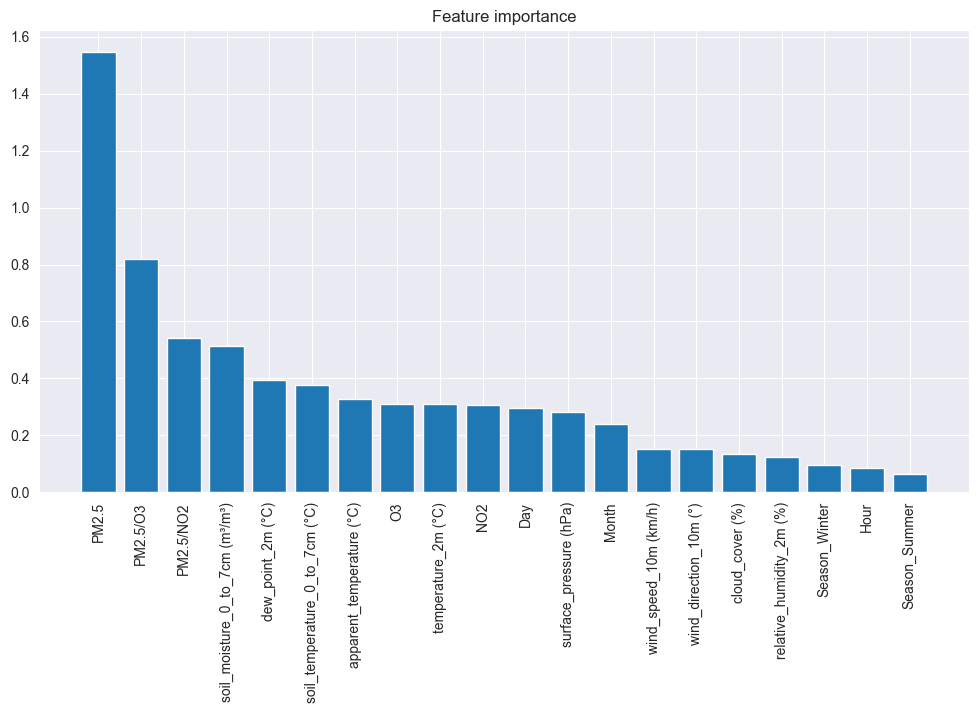

In [71]:
plt.figure(figsize=(12, 6))
plt.bar(feature_scores['Feature'][:20], feature_scores['Information_Gain'][:20])
plt.title('Feature importance')
plt.xticks(rotation=90)

Selecting the input features

In [72]:
# predicted feature and 3 most important features
output_data = ['PM10']
for i in feature_scores['Feature'][:2].tolist():
    output_data.append(i)

In [73]:
# tried using predicted feature and up to 3 more additional features
df[output_data].head()

PM10     PM2.5   PM2.5/O3
0  90.0  4.529345 -11.294744
1  86.0  4.606161   6.913660
2  86.0  4.606161   6.913660
3  78.0  4.560684   6.789403
4  78.0  4.560684   6.789403

In [74]:
print('Test data size:', test_data_size)

Test data size: 1125


In [75]:
print(output_data)
# predicted feature and selected features
input_columns = output_data

['PM10', 'PM2.5', 'PM2.5/O3']


In [76]:
filtered_df = df[input_columns]
dataset = filtered_df.values

In [77]:
test_data_size = round(0.2 * len(dataset))

train_data = dataset[:-test_data_size]
test_data = dataset[-test_data_size:]

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (4500, 3)
Test data shape: (1125, 3)


In [78]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [79]:
print('Window size:', window_size)

Window size: 48


In [80]:
def create_time_series(data, n_past):
    X, y = [], []
    for i in range(n_past, len(data)):
            X.append(data[i - n_past:i, 0:data.shape[1]])
            y.append(data[i,0])
    return np.array(X),np.array(y)

X_train, y_train = create_time_series(train_data, window_size)
X_test, y_test = create_time_series(test_data, window_size)

In [81]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (4452, 48, 3)
Shape of X_test: (1077, 48, 3)
Shape of y_train: (4452,)
Shape of y_test: (1077,)


In [82]:
print(X_train.shape[1])
print(X_train.shape[2])

48
3


In [422]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# lstm_model.add(Dropout(0.2))
# lstm_model.add(LSTM(50))
# lstm_model.add(Dropout(0.2))
# lstm_model.add(Dense(1))
# lstm_model.compile(optimizer='adam', loss='mse')

In [423]:
# hist = lstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

In [424]:
# predicted = lstm_model.predict(X_test, verbose=0)

In [425]:
# predicted_copy_array = np.repeat(predicted, len(input_columns), axis=-1)
# predicted_copy_array.shape

In [426]:
# pred = scaler.inverse_transform(np.reshape(predicted_copy_array,(len(predicted), len(input_columns))))[:,0]
# actual_copy_array = np.repeat(y_test, len(input_columns), axis=-1)
# actual = scaler.inverse_transform(np.reshape(actual_copy_array,(len(y_test), len(input_columns))))[:,0]

In [427]:
# mse = mean_squared_error(actual, pred)
# mae = mean_absolute_error(actual, pred)
# evs = explained_variance_score(actual, pred)
# 
# print(f'MSE: {mse:.2f}')
# print(f'MAE: {mae:.2f}')
# print(f'EVS: {evs:.2f}')

In [428]:
# output_df = {
#     'Date': dates[-test_data_size + window_size:],
#     'True': actual,
#     'Predicted': pred
# }

In [429]:
# output_df = pd.DataFrame(output_df)
# output_df.head(10)

In [83]:
def line_plot(plot_out_df):
    plt.figure(figsize=(12, 8))
    plt.plot(plot_out_df['Date'], plot_out_df['True'], label='True')
    plt.plot(plot_out_df['Date'], plot_out_df['Predicted'], label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value of PM10')
    plt.title('Value of PM10 through time')
    plt.legend()
    plt.show()

In [84]:
def line_plot_all_data(plot_df, plot_out_df):
    plt.figure(figsize=(12, 6))
    plt.plot(plot_df['Date'].iloc[:-test_data_size], plot_df['PM10'].iloc[:-test_data_size], label='Train')
    plt.plot(plot_out_df['Date'], plot_out_df['Predicted'], label='Predicted', color='green')
    plt.plot(plot_df['Date'].iloc[-test_data_size:], plot_df['PM10'].iloc[-test_data_size:], label='Test')
    plt.xlabel('Time')
    plt.ylabel('Value of PM10')
    plt.title('Value of PM10 through time')
    plt.legend()
    plt.show()

In [432]:
def create_lstm_model(units=32, dropout=0.0, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(16, activation=activation))
    model.add(Dense(1))
    
    model.compile(optimizer=optimizer, loss='mse')
    return model

def create_gru_model(units=32, dropout=0.0, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(GRU(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(units))
    model.add(Dropout(dropout))
    model.add(Dense(16, activation=activation))
    model.add(Dense(1))
    
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [85]:
def evaluate_model(actual, pred):
    mse = mean_squared_error(actual, pred)
    mae = mean_absolute_error(actual, pred)
    evs = explained_variance_score(actual, pred)
    
    print('Evaluation metrics:')
    print(f'MSE: {mse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'EVS: {evs:.2f}')
    
    return mse, mae, evs

In [86]:
def create_output_df(actual, pred):
    output_df = {
        'Date': dates[-test_data_size + window_size:],
        'True': actual,
        'Predicted': pred
    }
    
    output_df = pd.DataFrame(output_df)
    print(output_df.head(10))
    return output_df

In [435]:
params = {
    'model__units': [50, 64],
    'model__activation': ['relu', 'tanh', 'sigmoid'],
    'model__optimizer': ['adam', 'sgd'],
    'model__dropout': [0.1, 0.2],
    'epochs': [25, 30, 50],
    'batch_size': [32, 64, 128]
}

models = [create_lstm_model, create_gru_model]

score_metric = 'neg_mean_squared_error'
best_model = None
best_score = -float('inf')
best_models = {}

In [436]:
# randomized search
for model in models:
    model = KerasRegressor(model=model, verbose=0)
    randomized_search = RandomizedSearchCV(estimator=model,
                              param_distributions=params,
                              scoring=score_metric,
                              cv=3,
                              n_iter=10,
                              random_state=1234)
    randomized_search_results = randomized_search.fit(X_train, y_train, verbose=1, validation_data=(X_test, y_test))
    print(f'Best {score_metric}: {randomized_search_results.best_score_}')
    print('Best params:', randomized_search_results.best_params_)
    model_name = randomized_search_results.best_estimator_.model.__name__
    best_models[model_name] = {
        'score': randomized_search_results.best_score_,
        'params': randomized_search_results.best_params_,
    }

    if randomized_search_results.best_score_ > best_score:
        best_score = randomized_search_results.best_score_
        best_model = randomized_search_results.best_estimator_.model.__name__

Epoch 1/25
93/93 [==============================] - 11s 75ms/step - loss: 0.0056 - val_loss: 0.0084
Epoch 2/25
93/93 [==============================] - 2s 26ms/step - loss: 0.0232 - val_loss: 0.0241
Epoch 3/25
93/93 [==============================] - 2s 27ms/step - loss: 0.0062 - val_loss: 0.0082
Epoch 4/25
93/93 [==============================] - 2s 26ms/step - loss: 0.0032 - val_loss: 0.0121
Epoch 5/25
93/93 [==============================] - 2s 25ms/step - loss: 0.0035 - val_loss: 0.0062
Epoch 6/25
93/93 [==============================] - 2s 25ms/step - loss: 0.0029 - val_loss: 0.0104
Epoch 7/25
93/93 [==============================] - 2s 24ms/step - loss: 0.0026 - val_loss: 0.0077
Epoch 8/25
93/93 [==============================] - 2s 25ms/step - loss: 0.0023 - val_loss: 0.0076
Epoch 9/25
93/93 [==============================] - 2s 25ms/step - loss: 0.0023 - val_loss: 0.0123
Epoch 10/25
93/93 [==============================] - 2s 25ms/step - loss: 0.0022 - val_loss: 0.0050
Epoch 11

In [437]:
print('Best model:', best_model)
print(f'Best {score_metric}: {best_score}')

Best model: create_gru_model
Best neg_mean_squared_error: -0.0014547946128354021


Babysitting the model

In [87]:
optimizer = Adam(learning_rate=0.01)

In [88]:
model_1 = Sequential(name='LSTM')
model_1.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_1.add(Dropout(0.2))
model_1.add(LSTM(50))
model_1.add(Dropout(0.2))
model_1.add(Dense(1))
model_1.compile(optimizer=optimizer, loss='mean_squared_error')

# (best run score MSE: 39.6)
model_2 = Sequential(name='LSTM_2')
model_2.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(32))
model_2.add(Dropout(0.2))
model_2.add(Dense(1))
model_2.compile(optimizer=optimizer, loss='mean_squared_error')

# to complex and miss configured
model_3 = Sequential(name='GRU')
model_3.add(GRU(512, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_3.add(Dropout(0.2))
model_3.add(GRU(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_3.add(Dropout(0.2))
model_3.add(GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_3.add(Dropout(0.2))
model_3.add(GRU(64, return_sequences=True))
model_3.add(Dropout(0.2))
model_3.add(GRU(32))
model_3.add(Dense(1))
model_3.compile(optimizer=optimizer, loss='mean_squared_error')

model_4 = Sequential(name='GRU_2')
model_4.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_4.add(Dropout(0.2))
model_4.add(GRU(32))
model_4.add(Dropout(0.2))
model_4.add(Dense(16))
model_4.add(Dense(1))
model_4.compile(optimizer=optimizer, loss='mean_squared_error')

# the best model (best run score MSE: 36.7)
model_5 = Sequential(name='GRU_3')
model_5.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_5.add(Dropout(0.2))
model_5.add(GRU(50))
model_5.add(Dropout(0.2))
model_5.add(Dense(1))
model_5.compile(optimizer=optimizer, loss='mean_squared_error')

# didn't perform well
model_6 = Sequential()
model_6.add(Bidirectional(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)))
model_6.add(Dropout(0.2))
model_6.add(Bidirectional(LSTM(50)))
model_6.add(Dropout(0.2))
model_6.add(Dense(1))
model_6.compile(optimizer=optimizer, loss='mean_squared_logarithmic_error')

In [89]:
test_models = [model_5, model_1, model_2]

Epoch 1/50
70/70 [==============================] - 4s 32ms/step - loss: 0.0203 - val_loss: 0.0031
Epoch 2/50
70/70 [==============================] - 2s 25ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 3/50
70/70 [==============================] - 2s 25ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 4/50
70/70 [==============================] - 2s 24ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 5/50
70/70 [==============================] - 2s 25ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 6/50
70/70 [==============================] - 2s 25ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 7/50
70/70 [==============================] - 2s 24ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 8/50
70/70 [==============================] - 2s 24ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 9/50
70/70 [==============================] - 2s 24ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 10/50
70/70 [==============================] - 2s 25ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 11/

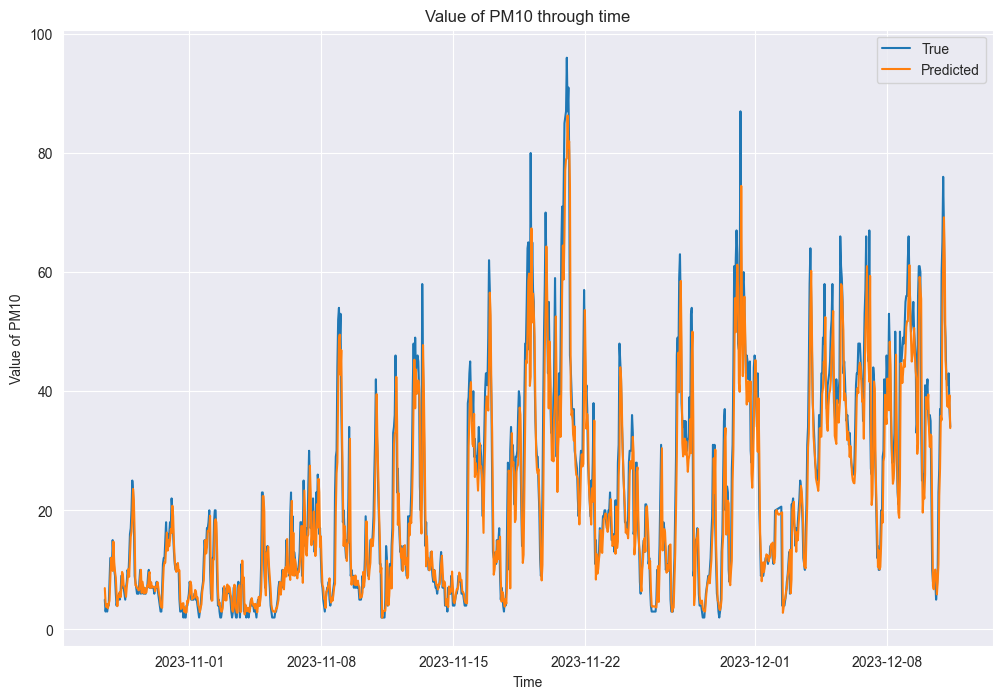

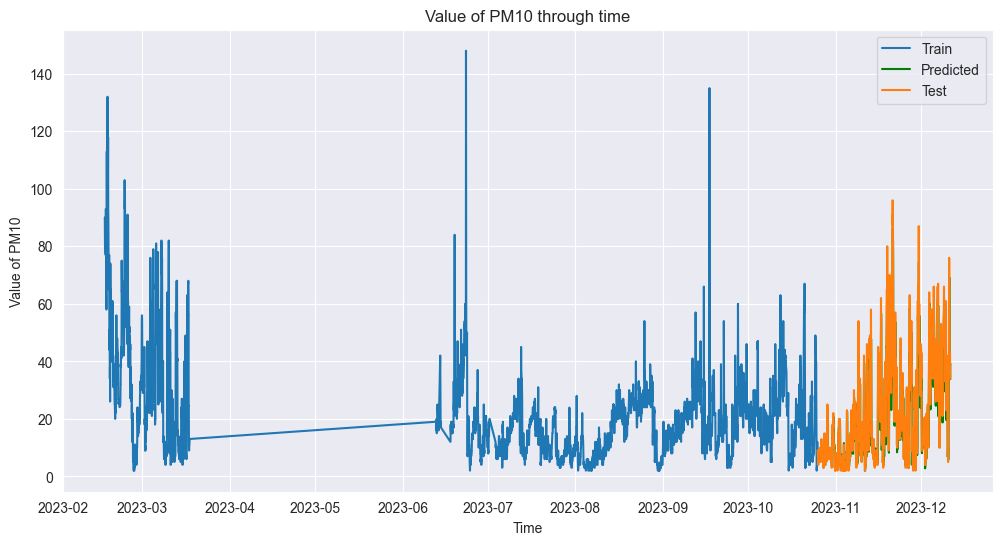

Epoch 1/50
70/70 [==============================] - 4s 34ms/step - loss: 0.2590 - val_loss: 0.0081
Epoch 2/50
70/70 [==============================] - 2s 25ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 3/50
70/70 [==============================] - 2s 24ms/step - loss: 0.0051 - val_loss: 0.0084
Epoch 4/50
70/70 [==============================] - 2s 26ms/step - loss: 0.0042 - val_loss: 0.0055
Epoch 5/50
70/70 [==============================] - 2s 26ms/step - loss: 0.0032 - val_loss: 0.0056
Epoch 6/50
70/70 [==============================] - 2s 26ms/step - loss: 0.0031 - val_loss: 0.0063
Epoch 7/50
70/70 [==============================] - 2s 25ms/step - loss: 0.0028 - val_loss: 0.0054
Epoch 8/50
70/70 [==============================] - 2s 25ms/step - loss: 0.0026 - val_loss: 0.0050
Epoch 9/50
70/70 [==============================] - 2s 26ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 10/50
70/70 [==============================] - 2s 25ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 11/

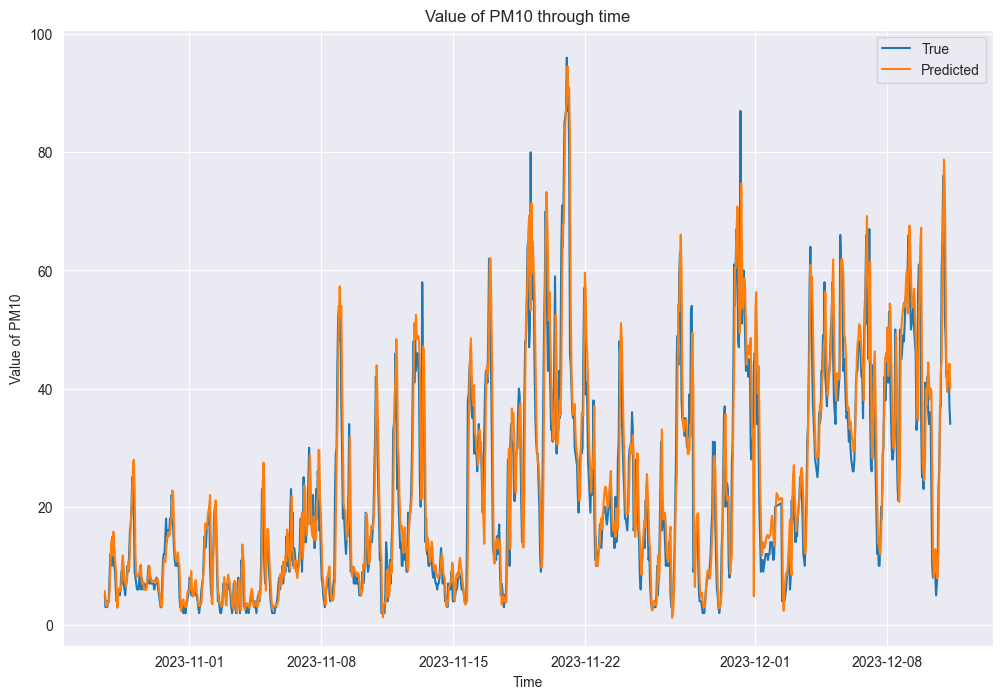

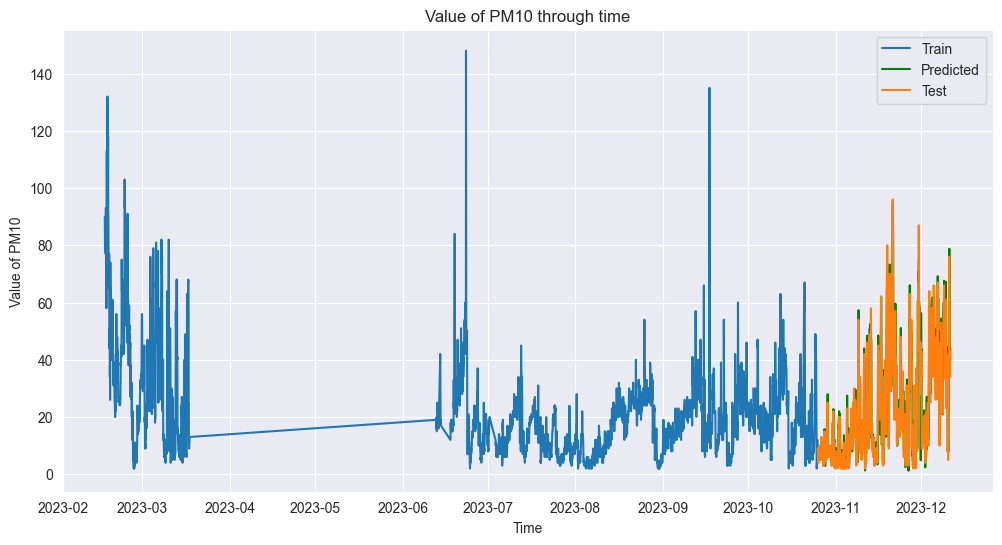

Epoch 1/50
70/70 [==============================] - 4s 32ms/step - loss: 0.1003 - val_loss: 0.0150
Epoch 2/50
70/70 [==============================] - 2s 22ms/step - loss: 0.0158 - val_loss: 0.0146
Epoch 3/50
70/70 [==============================] - 2s 22ms/step - loss: 0.0146 - val_loss: 0.0141
Epoch 4/50
70/70 [==============================] - 2s 22ms/step - loss: 0.0109 - val_loss: 0.0082
Epoch 5/50
70/70 [==============================] - 2s 22ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 6/50
70/70 [==============================] - 2s 22ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 7/50
70/70 [==============================] - 2s 22ms/step - loss: 0.0041 - val_loss: 0.0060
Epoch 8/50
70/70 [==============================] - 2s 22ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 9/50
70/70 [==============================] - 2s 22ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 10/50
70/70 [==============================] - 2s 22ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 11/

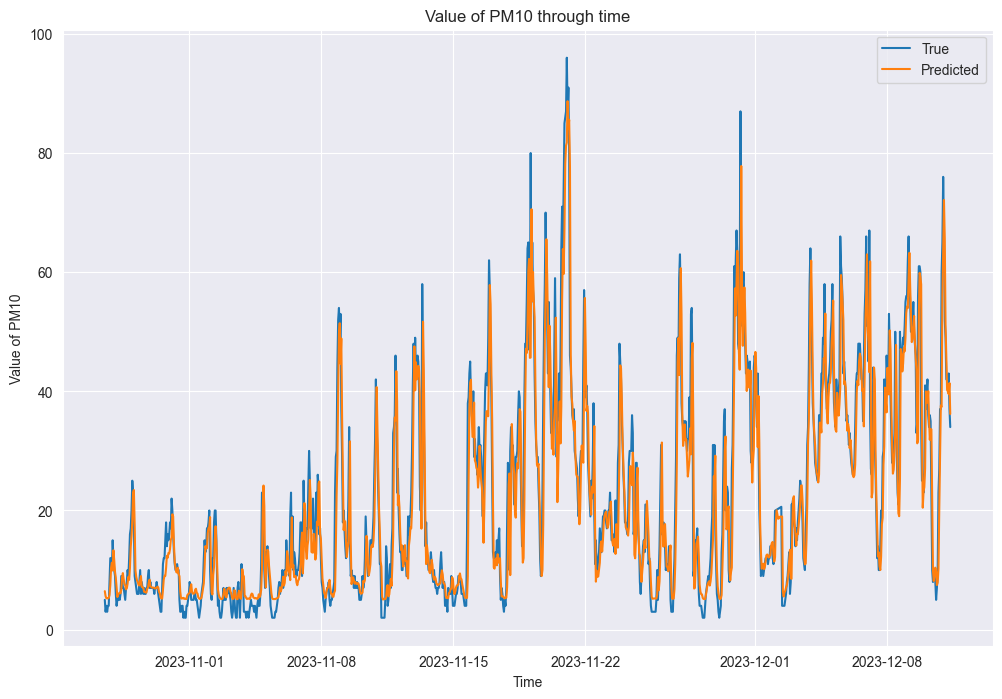

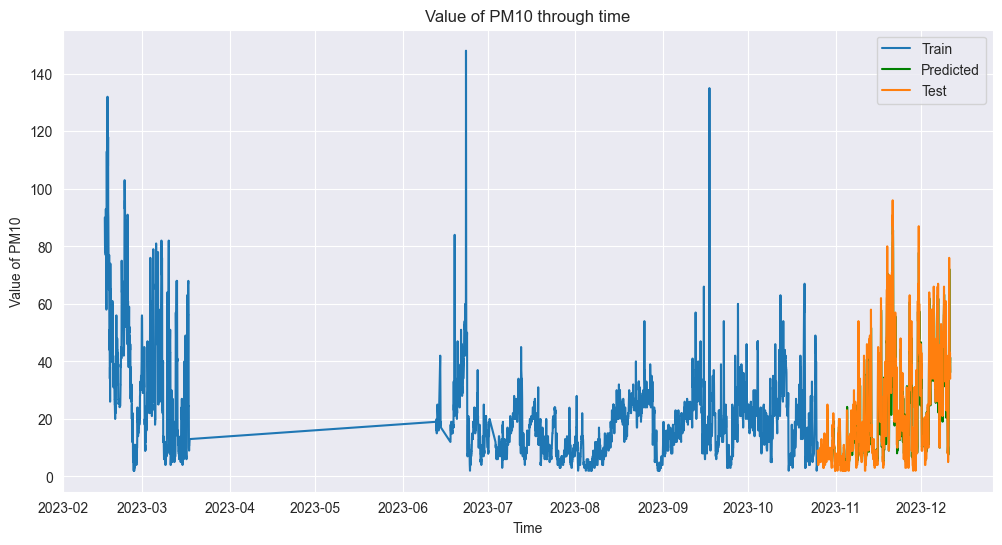

In [90]:
history = {}
results = {
        'MSE': [],
        'MAE': [],
        'EVS': []
    }
for model in test_models:
    hist = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)
    history[model.name] = hist.history

    predicted = model.predict(X_test, verbose=0)
    predicted_copy_array = np.repeat(predicted, len(input_columns), axis=-1)

    print('Predicted shape:', predicted_copy_array.shape)

    pred = scaler.inverse_transform(np.reshape(predicted_copy_array,(len(predicted), len(input_columns))))[:,0]
    actual_copy_array = np.repeat(y_test, len(input_columns), axis=-1)
    actual = scaler.inverse_transform(np.reshape(actual_copy_array,(len(y_test), len(input_columns))))[:,0]

    mse, mae, evs = evaluate_model(actual, pred)
    
    results['MSE'].append((model.name, mse))
    results['MAE'].append((model.name, mae))
    results['EVS'].append((model.name, evs))
    
    output_df = create_output_df(actual, pred)

    line_plot(output_df)
    line_plot_all_data(df, output_df)

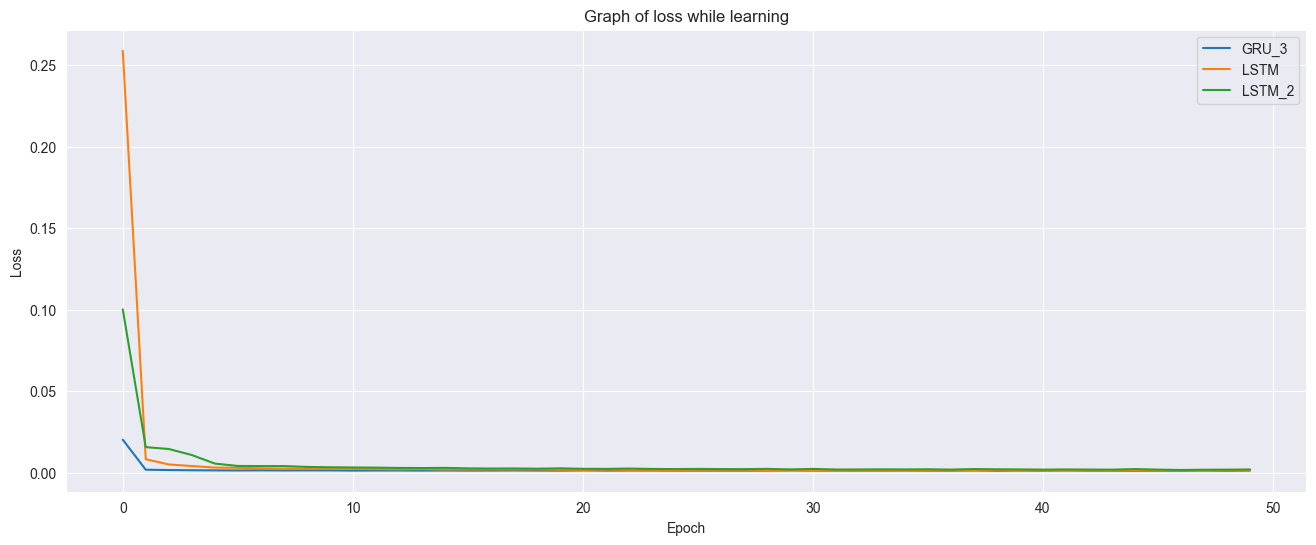

In [91]:
plt.figure(figsize=(16, 6))
for name, values in history.items():
    plt.plot(values['loss'], label=name)
plt.title('Graph of loss while learning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

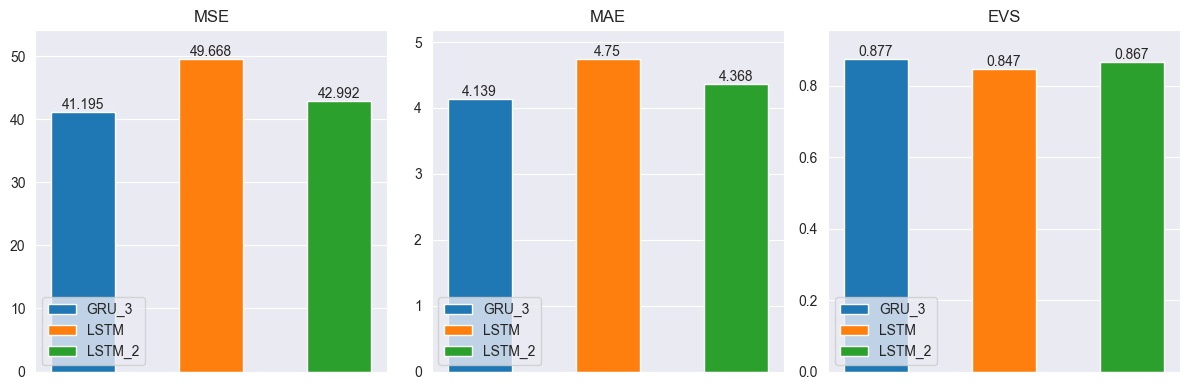

In [92]:
width = 0.5
rows = 1
cols = len(metrics)

fig, axs = plt.subplots(rows, cols, figsize=(12, 4))

for i, metric in enumerate(metrics):
    ax = axs[i]
    max = -float('inf')


    for j, model in enumerate(test_models):
        value = results[metric][j][1]
        if value > max:
          max = value
        ax.bar(j, value, width, label=model.name)
        ax.text(j, value, str(round(value, 3)), ha='center', va='bottom')


    ax.set_ylim([0, max * 1.09])
    ax.set_title(f'{metric}')
    ax.set_xticks([], [])
    ax.legend(loc='lower left')

plt.tight_layout()
plt.show()

In [96]:
# final model
out_model = Sequential(name='GRU_3')
out_model.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
out_model.add(Dropout(0.2))
out_model.add(GRU(50))
out_model.add(Dropout(0.2))
out_model.add(Dense(1))
out_model.compile(optimizer=optimizer, loss='mean_squared_error')

In [97]:
train_data = dataset
train_data = scaler.fit_transform(train_data)

X_train, y_train = create_time_series(train_data, window_size)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (5577, 48, 3)
Shape of y_train: (5577,)


In [98]:
hist = out_model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)

Epoch 1/50
88/88 [==============================] - 4s 25ms/step - loss: 0.1165
Epoch 2/50
88/88 [==============================] - 2s 23ms/step - loss: 0.0126
Epoch 3/50
88/88 [==============================] - 2s 22ms/step - loss: 0.0127
Epoch 4/50
88/88 [==============================] - 2s 21ms/step - loss: 0.0124
Epoch 5/50
88/88 [==============================] - 2s 23ms/step - loss: 0.0129
Epoch 6/50
88/88 [==============================] - 2s 22ms/step - loss: 0.0122
Epoch 7/50
88/88 [==============================] - 2s 22ms/step - loss: 0.0115
Epoch 8/50
88/88 [==============================] - 2s 22ms/step - loss: 0.0117
Epoch 9/50
88/88 [==============================] - 2s 22ms/step - loss: 0.0138
Epoch 10/50
88/88 [==============================] - 2s 23ms/step - loss: 0.0109
Epoch 11/50
88/88 [==============================] - 2s 22ms/step - loss: 0.0117
Epoch 12/50
88/88 [==============================] - 2s 21ms/step - loss: 0.0105
Epoch 13/50
88/88 [==================

In [332]:
filename = f'out/finalized_model.h5'
out_model.save(filename)

with open(f'out/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

/Users/gregorsulcer/PycharmProjects/projektna_sulcer/.venv/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
